# Kaggle Playground Series S3E19 - Forecasting sales of fictitious stores

This is the 1st winning solution of the competition

https://www.kaggle.com/competitions/playground-series-s3e19

The original notebook/discussion can be found at this link:

https://www.kaggle.com/code/ivyzang/1st-place-solution-less-is-more

In this modified notebook, our aim is to understand and replicate the solution. 

In [17]:
#!pip uninstall holidays -y
#!pip install holidays==0.18

In [18]:
import datetime as dt
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
pd.options.mode.chained_assignment = None  # default='warn'
train = pd.read_csv('../input/playground-series-s3e19/train.csv')
test = pd.read_csv('../input/playground-series-s3e19/test.csv')
test['num_sold'] = 300  # this is dummy for simplify concat

import matplotlib
matplotlib.rcParams.update({'font.size': 15})

In [19]:
import holidays
holidays.__version__

'0.24'

# 1. Analyze the data distribution

Utilizing sales data spanning the years 2017 through 2021, our aim is to construct a predictive model for forecasting 'num_sold' for the upcoming year of 2022. This forecasting relies on the comprehensive understanding of four elements: date, country, store, and the distinct product category. Therefore, our preliminary step is to systematically analyze the relation between 'num_sold' and each of these four parameters.

In [20]:
train.head(5)

,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49


In [21]:
# Creating variables for analysis
analysis = train.drop(columns='id')
# date column is separated for each element
analysis['date'] = pd.to_datetime(analysis['date'])
analysis['day'] = analysis['date'].dt.day
analysis['week'] = analysis['date'].dt.dayofweek
analysis['month'] = analysis['date'].dt.month
analysis['year'] = analysis['date'].dt.year
analysis['day_of_year'] = analysis['date'].dt.dayofyear
analysis['time_no'] = (
    analysis['date'] - dt.datetime(2017, 1, 1)) // dt.timedelta(days=1)
analysis.loc[analysis['date'] > dt.datetime(2020, 2, 29), 'time_no'] -= 1
date_columns = ['date', 'day', 'week', 'month', 'year', 'time_no']


In [22]:
uniques = {}
for column in analysis.columns:
    uniques[column] = analysis[column].unique().tolist()
print(uniques['country'])
print(uniques['store'])
print(uniques['product'])

['Argentina', 'Canada', 'Estonia', 'Japan', 'Spain']
['Kaggle Learn', 'Kaggle Store', 'Kagglazon']
['Using LLMs to Improve Your Coding', 'Using LLMs to Train More LLMs', 'Using LLMs to Win Friends and Influence People', 'Using LLMs to Win More Kaggle Competitions', 'Using LLMs to Write Better']


### 1.1 Check store

In [23]:
grouped_data = analysis.groupby(['date', 'store'])['num_sold'].sum().reset_index()
grouped_data 

,date,store,num_sold
0,2017-01-01,Kagglazon,13882
1,2017-01-01,Kaggle Learn,2464
2,2017-01-01,Kaggle Store,3740
3,2017-01-02,Kagglazon,10636
4,2017-01-02,Kaggle Learn,1950
...,...,...,...
5473,2021-12-30,Kaggle Learn,2437
5474,2021-12-30,Kaggle Store,3806
5475,2021-12-31,Kagglazon,14133
5476,2021-12-31,Kaggle Learn,2509


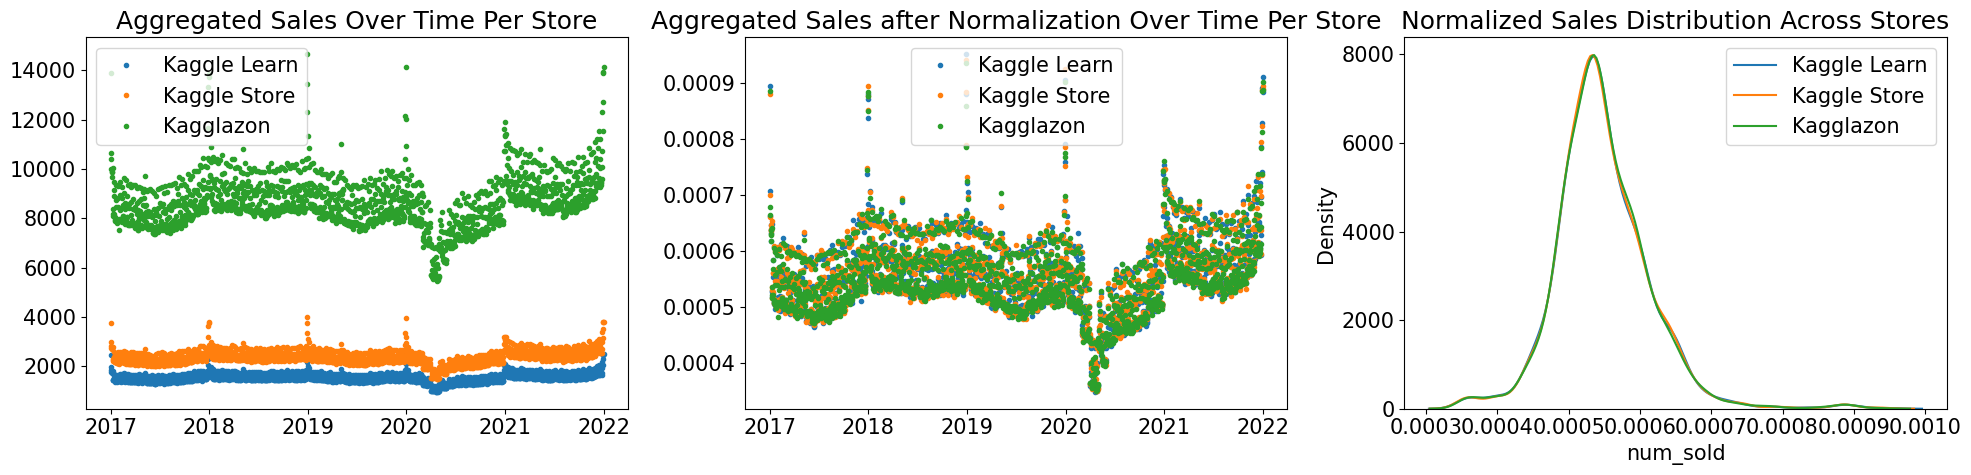

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for store in uniques['store']:
    store_data = grouped_data[grouped_data['store'] == store]
    sum_store=grouped_data[grouped_data['store'] == store]['num_sold'].sum()
    axs[0].plot(store_data['date'], store_data['num_sold'], ".", label=store)
    axs[1].plot(store_data['date'], store_data['num_sold']/sum_store, ".", label=store)
    axs[2] = sns.kdeplot(store_data['num_sold']/sum_store, label=store, ax=axs[2])
    
axs[0].legend()
axs[0].set_title('Aggregated Sales Over Time Per Store')
axs[1].legend()
axs[1].set_title('Aggregated Sales after Normalization Over Time Per Store')
axs[2].legend()
axs[2].set_title('Normalized Sales Distribution Across Stores')

plt.tight_layout()
plt.show()

Upon examining the stores, it appears that each displays a similar sales distribution, only differentiated by a scalar constant. This pattern emerges when normalizing each store's sales by its total sales and comparing the distributions, as shown above.

### 1.2 Check country

In [25]:
grouped_data_country = analysis.groupby(['date', 'country'])['num_sold'].sum().reset_index()
grouped_data_country

,date,country,num_sold
0,2017-01-01,Argentina,2011
1,2017-01-01,Canada,6134
2,2017-01-01,Estonia,2772
3,2017-01-01,Japan,5274
4,2017-01-01,Spain,3895
...,...,...,...
9125,2021-12-31,Argentina,1397
9126,2021-12-31,Canada,7347
9127,2021-12-31,Estonia,4094
9128,2021-12-31,Japan,3644


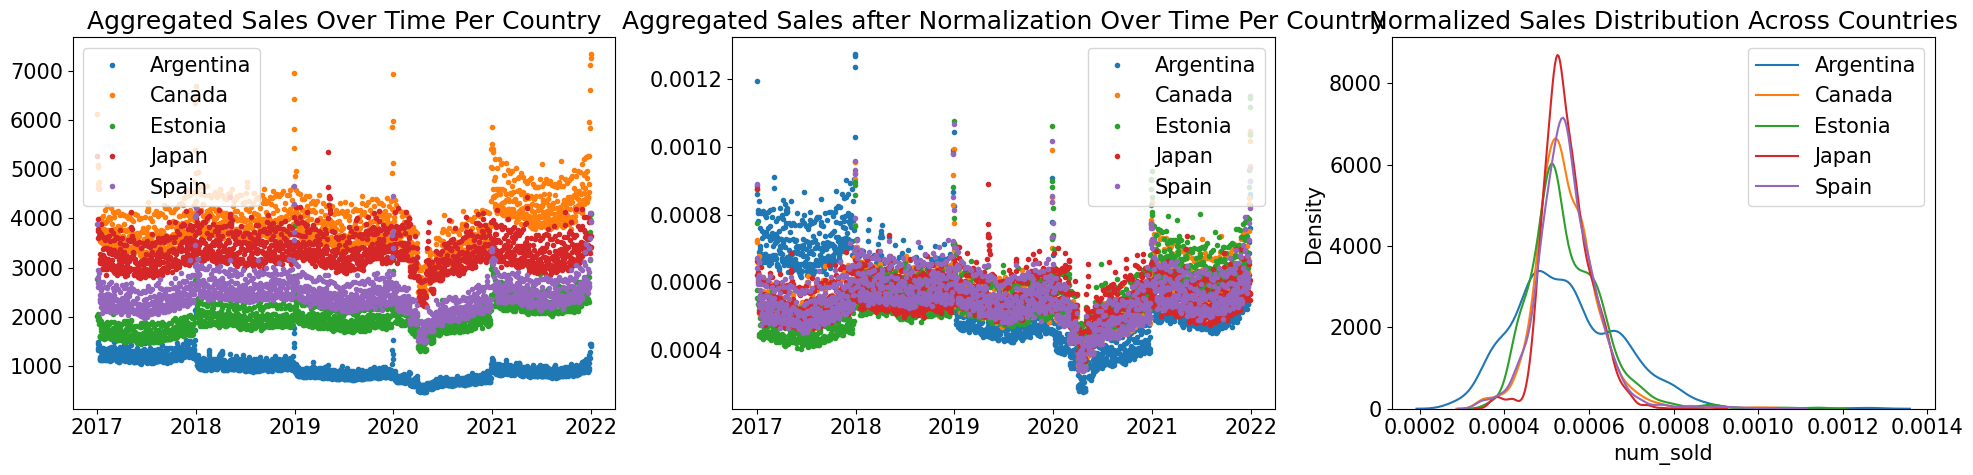

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for country in uniques['country']:
    country_data = grouped_data_country[grouped_data_country['country'] == country]
    sum_country = country_data['num_sold'].sum()
    # 1st plot
    axs[0].plot(country_data['date'], country_data['num_sold'], ".", label=country)
    # 2nd plot
    axs[1].plot(country_data['date'], country_data['num_sold']/sum_country,
                ".", label=country)
    # 3rd plot
    axs[2] = sns.kdeplot(country_data['num_sold']/sum_country, label=country)
    
axs[0].legend()
axs[0].set_title('Aggregated Sales Over Time Per Country')
axs[1].legend()
axs[1].set_title('Aggregated Sales after Normalization Over Time Per Country')
axs[2].legend()
axs[2].set_title('Normalized Sales Distribution Across Countries')
plt.tight_layout()
plt.show()

Our analysis reveals several insights:

1. There is a distinct separation in the num_sold across different years. This likely means that the sales volume has changed significantly from year to year.
2. Within each year, num_sold follows a consistent pattern across different countries, although the magnitude of change between years varies from country to country.

Based on these observations, we have 2 different approaches for our prediction model:

1. Assuming that sales in 2022 will follow a similar trend as in 2021, we can adjust the num_sold values for each year to match the 2021 level. By utilizing this adjusted data, we aim to make more accurate predictions for sales in 2022.
2. Instead of manually adjusting the levels, we can investigate if other available variables can explain the differences observed among different countries. Using these variables may improve the accuracy of our predictions.

Approach 1: (inspired from the winning solution in the past year https://www.kaggle.com/code/kitadakiyoto/tpssep22-predict-by-linear-regression-1st-place This post is really helpful and I learned a lot from it ^^) 

Below we've normalized the sales data from 2017 to 2020 to the 2021 level by adjusting for the average annual sales for each country.
Specifically, we use the data duing Jan.11th- February (no holiday) for each year and calculate the mean value for each country. Then num_sold is normalized by using this mean value. We see that the normalized data has the same distribution for different countries.


In [27]:
df = analysis.groupby(['date', 'country'], as_index=False).mean()
df_not_outlier = df.copy()
df_not_outlier = df_not_outlier.loc[df_not_outlier['month'].isin([1,2])]
df_not_outlier = df_not_outlier.loc[(df_not_outlier['month'] == 2) | (df_not_outlier['day'] >= 11)]
df_not_outlier = df_not_outlier.loc[(df_not_outlier['month'] == 1) | (df_not_outlier['day'] <= 14)]
change = df_not_outlier.groupby(['country', 'year'], as_index=False).mean()
change = change[['country', 'year', 'num_sold']]

for year in [2017,2018,2019,2020,2021]:
    df = pd.merge(df, change.loc[change['year']==year].rename(columns={'num_sold':f'c{year}'}).drop(columns='year'),
                  on=['country'])
df.loc[df['year'] == 2017, 'num_sold'] /= df['c2017']
df.loc[df['year'] == 2018, 'num_sold'] /= df['c2018']
df.loc[df['year'] == 2019, 'num_sold'] /= df['c2019']
df.loc[df['year'] == 2020, 'num_sold'] /= df['c2020']
df.loc[df['year'] <2021, 'num_sold'] *= df['c2021']

/tmp/ipykernel_33/949416729.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = analysis.groupby(['date', 'country'], as_index=False).mean()
/tmp/ipykernel_33/949416729.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  change = df_not_outlier.groupby(['country', 'year'], as_index=False).mean()


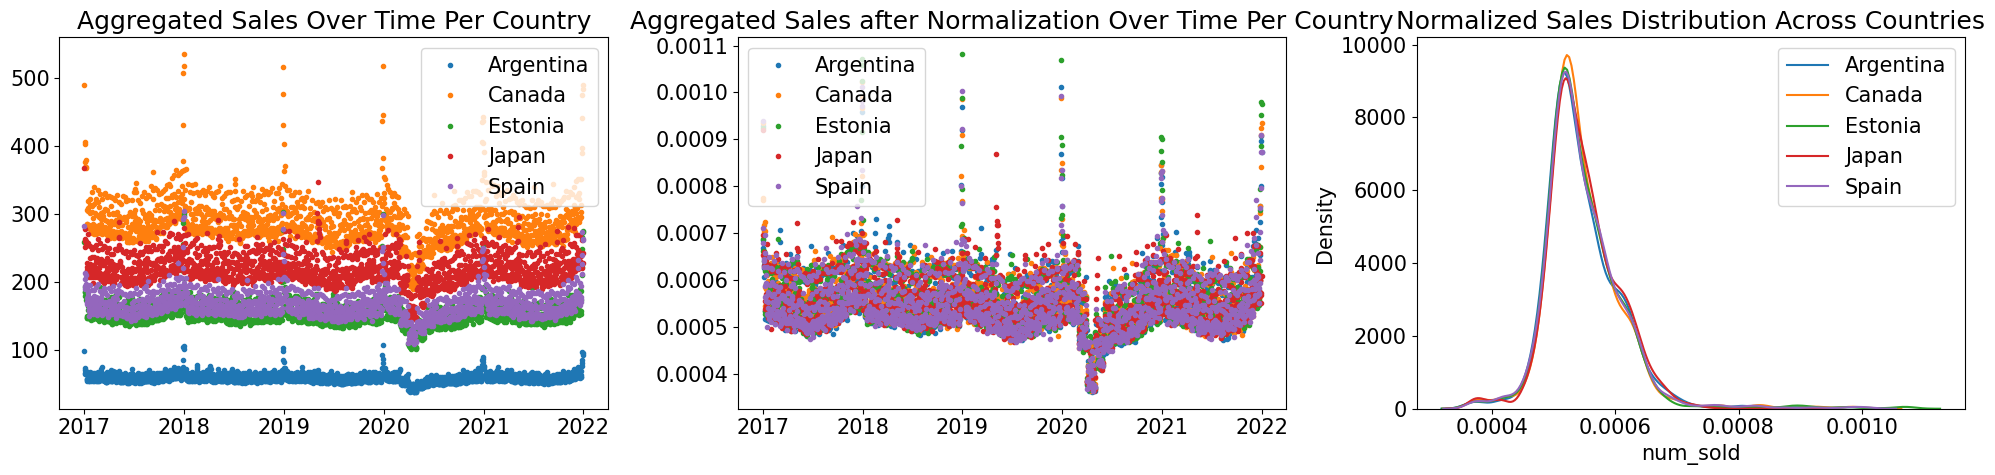

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for country in uniques['country']:
    country_data = df[df['country'] == country]
    axs[0].plot(country_data['date'], country_data['num_sold'], ".", label=country)
axs[0].legend()
axs[0].set_title('Aggregated Sales Over Time Per Country')

# Second plot
for country in uniques['country']:
    country_data = df[df['country'] == country]
    axs[1].plot(country_data['date'], country_data['num_sold']/country_data['num_sold'].sum(), ".", label=country)
axs[1].legend()
axs[1].set_title('Aggregated Sales after Normalization Over Time Per Country')

# Third plot
for country in uniques['country']:
    country_data = df[df['country'] == country]
    axs[2] = sns.kdeplot(country_data['num_sold']/country_data['num_sold'].sum(), label=country)
axs[2].legend()
axs[2].set_title('Normalized Sales Distribution Across Countries')
plt.tight_layout()
plt.show()

Approach 2. (https://www.kaggle.com/competitions/playground-series-s3e19/discussion/423919) this post points out the year difference is due to the gdp difference in different countries. Therefore we can use gdp as an external predictor.

In [29]:
import requests
def get_gdp_per_capita(country, year):
    alpha3 = {'Argentina': 'ARG', 'Canada': 'CAN',
              'Estonia': 'EST', 'Japan': 'JPN', 'Spain': 'ESP'}
    url = "https://api.worldbank.org/v2/country/{0}/indicator/NY.GDP.PCAP.CD?date={1}&format=json".format(
        alpha3[country], year)
    response = requests.get(url).json()
    return response[1][0]['value']

gdp = []
for country in train.country.unique():
    row = []
    for year in range(2017, 2023):
        row.append(get_gdp_per_capita(country, year))
    gdp.append(row)
    
gdp = np.array(gdp)
gdp /= np.sum(gdp) #to renomralize the data


In [30]:
rel_gdp_df = pd.DataFrame(gdp, index=analysis.country.unique(), columns=range(2017, 2023))

df= analysis.groupby(['date', 'country'])[['num_sold']].sum().reset_index()
df['rel_gdp'] = df.apply(lambda s: rel_gdp_df.loc[s.country, s.date.year], axis=1)
df

,date,country,num_sold,rel_gdp
0,2017-01-01,Argentina,2011,0.015987
1,2017-01-01,Canada,6134,0.049373
2,2017-01-01,Estonia,2772,0.022360
3,2017-01-01,Japan,5274,0.042486
4,2017-01-01,Spain,3895,0.030836
...,...,...,...,...
9125,2021-12-31,Argentina,1397,0.011652
9126,2021-12-31,Canada,7347,0.057453
9127,2021-12-31,Estonia,4094,0.030571
9128,2021-12-31,Japan,3644,0.043825


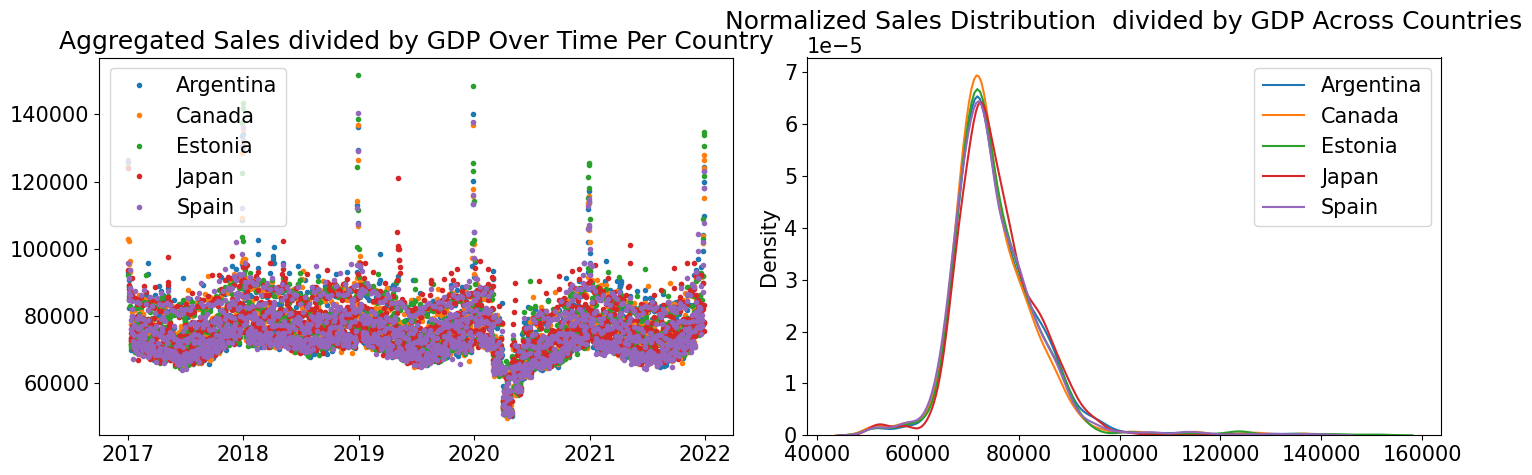

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for country in uniques['country']:
    country_data = df[df['country'] == country]
    axs[0].plot(country_data['date'], country_data['num_sold']/country_data['rel_gdp'],
                ".", label=country)
    axs[1] = sns.kdeplot(country_data['num_sold']/country_data['rel_gdp'], label=country)
    
axs[0].legend()
axs[0].set_title('Aggregated Sales divided by GDP Over Time Per Country')
axs[1].legend()
axs[1].set_title(
    'Normalized Sales Distribution  divided by GDP Across Countries')
plt.tight_layout()
plt.show()

We can see that each country have roughly the same distribution after normalized by gdp. 
While they are still slightly different, possibly due to the different holiday celebration dates.

I have attempted to adjust the holiday celebration dates to minimize the differences(shown below), but despite my efforts, some variations still persist. It is probably due to random errors or other effects.


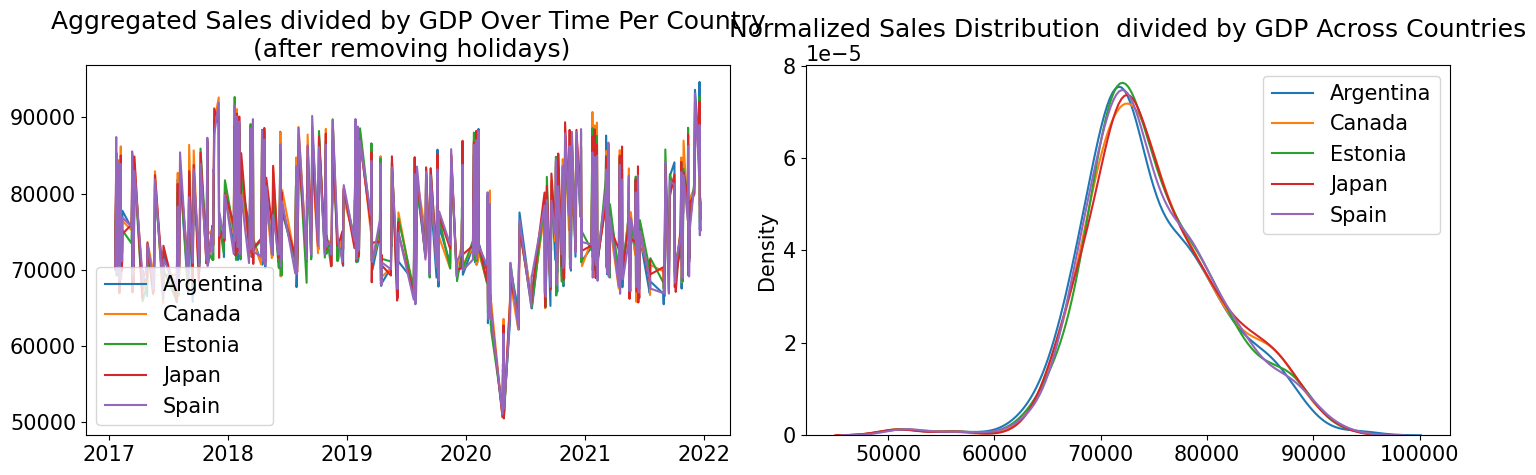

In [32]:
# Generate holidays for each country and year
import holidays
for year in [2017, 2018, 2019, 2020,2021]:
    for country in uniques['country'][:]:
        for date, holiday_name in sorted(holidays.CountryHoliday(country, years=year).items()):
            df = df[~((df['date'].dt.date >= date) & (
                df['date'].dt.date < date+dt.timedelta(days=10)))]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for country in uniques['country']:
    country_data = df[df['country'] == country]
    axs[0].plot(country_data['date'], country_data['num_sold'] /
                country_data['rel_gdp'],label=country)
    axs[1] = sns.kdeplot(country_data['num_sold'] /
                         country_data['rel_gdp'], label=country)
axs[0].legend()
axs[0].set_title(f'Aggregated Sales divided by GDP Over Time Per Country\n (after removing holidays)')
axs[1].legend()
axs[1].set_title(
    'Normalized Sales Distribution  divided by GDP Across Countries')
plt.tight_layout()
plt.show()


I think we can use either apporach to normalize the data but the second one looks more stable.
(And later when we check the public leadboard we will realize that there is a wierd thing happening in 2022: all sales accross different countries move to the same level. so actually we won't need the gdp data for 2022.)

### 1.4 check product

Text(0.5, 1.0, 'Aggregated Sales after Normalization Over Time Per Product')

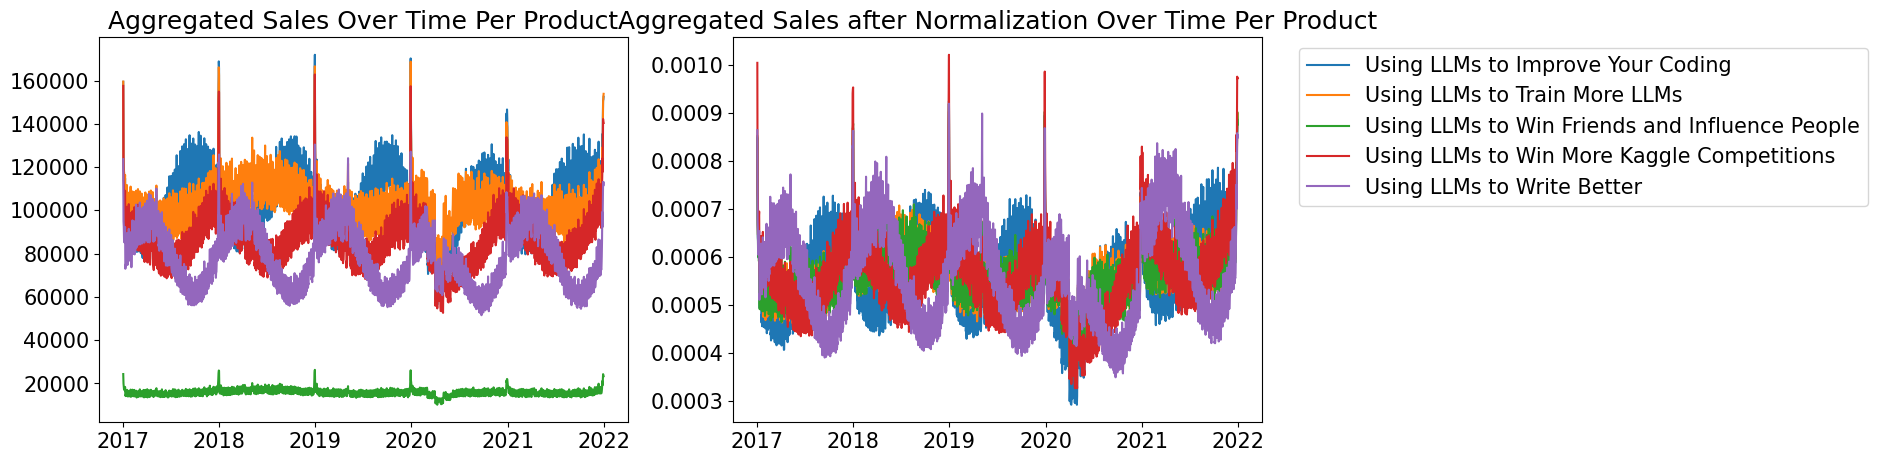

In [33]:
# First plot

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

grouped_data = analysis.groupby(['date', 'country','product'])['num_sold'].sum().reset_index()
grouped_data['rel_gdp'] = grouped_data .apply(lambda s: rel_gdp_df.loc[s.country, s.date.year], axis=1)
grouped_data['num_sold'] = grouped_data['num_sold']/grouped_data['rel_gdp']
grouped_data = grouped_data.groupby(['date','product'])['num_sold'].sum().reset_index()
for product in uniques['product']:
    product_data = grouped_data[grouped_data['product'] == product]
    axs[0].plot(product_data['date'], product_data['num_sold'],label=product)
#axs[0].legend()
axs[0].set_title('Aggregated Sales Over Time Per Product')


grouped_data = analysis.groupby(['date', 'product'])['num_sold'].sum().reset_index()
for product in uniques['product']:
    product_data = grouped_data[grouped_data['product'] == product]
    axs[1].plot(product_data['date'], product_data['num_sold']/product_data['num_sold'].sum(),label=product)
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[1].set_title('Aggregated Sales after Normalization Over Time Per Product')

For each product, we observe the sales trend to exhibit both sine and cosine components, indicative of a cyclical pattern. However, the amplitudes of these cyclical components vary across different products. So we will treat the products separately. 

Furthermore, there are distinct sales peaks that align with holiday seasons. 

The year 2020 is different because of covid.

### 1.3 check covid effect

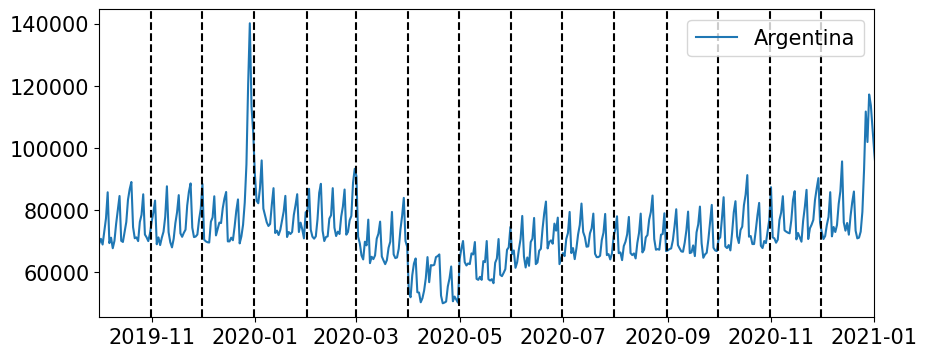

In [34]:

df_check = analysis.groupby(['date', 'country'])[['num_sold']].sum().reset_index()
df_check['rel_gdp'] = df_check.apply(
    lambda s: rel_gdp_df.loc[s.country, s.date.year], axis=1)
fig = plt.figure(figsize=(10, 4))
for i, country in enumerate(uniques['country'][:1]):
    X = df_check[df_check['country'] == country]
    plt.plot(X['date'], X['num_sold']/X['rel_gdp'], label=country)
    plt.legend()
    plt.xlim([dt.date(2019, 10, 1), dt.date(2021, 1, 1)])
    for i in range(10, 13):
        datetime1 = dt.datetime(2019, i, 1) - dt.timedelta(days=1)
        datetime2 = dt.datetime(2019, i, 1)
        mid_datetime = datetime1 + (datetime2 - datetime1) / 2
        plt.axvline(mid_datetime, color='k', linestyle='--')
    for i in range(1, 13):
        datetime1 = dt.datetime(2020, i, 1) - dt.timedelta(days=1)
        datetime2 = dt.datetime(2020, i, 1)
        mid_datetime = datetime1 + (datetime2 - datetime1) / 2
        plt.axvline(mid_datetime, color='k', linestyle='--')


I plot the num_sold for one example country in 2020. We can see that covid acts as a monthly effect. (And it is clearly a generated effect, since I feel that in a real world, it should be a gradual effect, instead of a sudden drop/jump). We will add additional monthly features to capture this covid effect.

### 1.3 check weekday and weekends

We see that the distribution of Monday-Thursday are the same, while Firday-Sunday are different. 

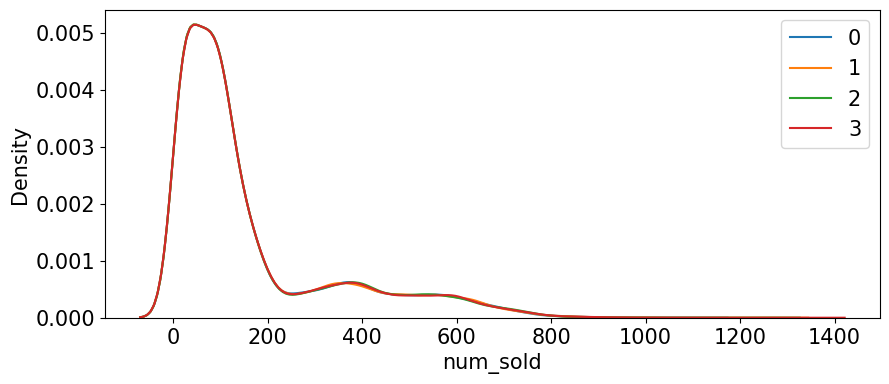

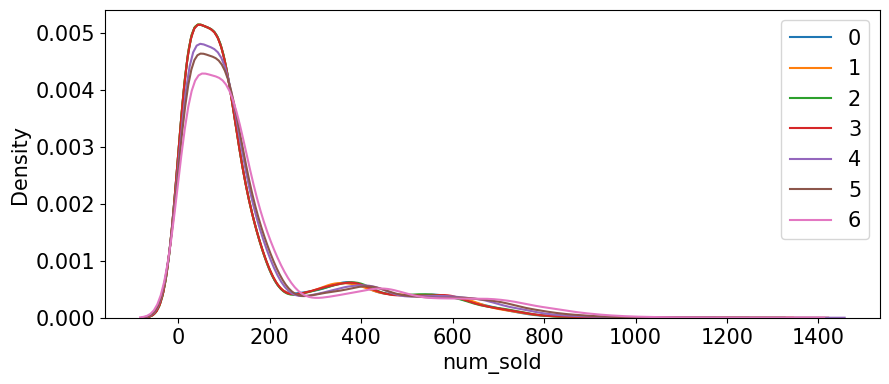

In [35]:
fig = plt.figure(figsize=(10, 4))
for w in [0,1,2,3]:
    w_data = analysis[analysis['week'] == w]['num_sold']
    sns.kdeplot(w_data, label=w)
plt.legend()
plt.show()
fig = plt.figure(figsize=(10, 4))
for w in [0, 1, 2, 3,4,5,6]:
    w_data = analysis[analysis['week'] == w]['num_sold']
    sns.kdeplot(w_data, label=w)
plt.legend()
plt.show()


# 2. Linear Regression (first round)


The evaluation metric is SMAPE, 

$\mathrm{SMAPE}=\frac{200}{n} \sum_{t=1}^{n} \frac{\left|F_{t}-A_{t}\right|}{\left(\left|A_{t}\right|+\left|F_{t}\right|\right) }\propto \sum_{t=1}^{n} \frac{\left|F_{t}/A_{t}-1\right|}{\left(1+\left|F_{t}\right|/\left|A_{t}\right|\right) }=\sum_{F_t>A_t} 1- \frac{2}{\left(1+F_{t}/A_{t}\right) } +\sum_{F_t<A_t} -1 + \frac{2}{\left(1+F_{t}/A_{t}\right) }$


Roughly speaking, the metric is to make $F_t/A_t$ as close to 1 as possbile. Therefore, We will use the log-transformed sales as the target, since $ln(A_t)-ln(F_t)$ is more sensitive to the deviation of $F_t/A_t$ from 1 than $A_t-F_t$. 

log-transformed sales are also good to decompose multication into addition, which is easier for the model to learn.


### Model:


\begin{equation}
\text{sold} = \text{GDP}(\text{country}, \text{year}) \times \text{const}(\text{store}) \times \left[ \text{sine/cosine waves}(\text{product}) + \text{holiday} + \text{weekday} + \text{covid} \right]
\end{equation}

Taking the natural logarithm on both sides gives:

\begin{equation}
\ln(\text{sold}) = \ln(\text{GDP}) + b_1*\text{const(store)} + \ln\left[ \text{waves(product)} + \text{holiday} + \text{weekend} + \text{covid} \right]
\end{equation}

For the last term, ln(1+x)~x. wave is a big number compared to other effects, so

\begin{equation}
\ln\left[ \text{waves(product)} + \text{holiday} + \text{weekend} + \text{covid} \right] \approx \ln\left[ \text{waves(product)} \right] + \left[ \text{holiday effect} + \text{weekend} + \text{covid effect} \right]
\end{equation}

Thus, the final model becomes:

\begin{equation}
\ln(\text{sold}) = \ln(\text{GDP}) + b_1\text{const(store)} + b_2\text{(product)}+b_3\text{waves(product)} + b_4\text{holiday effect} + b_5\text{weekend} + b_6\text{covid}
\end{equation}

(I tried using gdp as a fitting predictor, but the coefficient is like 1.00001)

For holiday effect, 

$b_4*\text{holiday effect}= b_{40}*\text{holiday day0} +b_{41}*\text{holiday day1} +..b_{410}*\text{holiday day10} $

the 'num_sold' will be affected by the holiday not only on the holiday itself but also on all the following days. To capture this effect, we propose a model that considers a series of coefficients individual coefficients, such as $b_{40}$, $b_{41}$, and so on up to $b_{410}$, correspond to the impact of the holiday on day0, day1, and up to day10 after the holiday, respectively. 



In [36]:
df = pd.concat([train, test], axis=0)
df['log'] = np.log(df['num_sold'])
# add date
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['time_no'] = (df['date'] - dt.datetime(2017, 1, 1)) // dt.timedelta(days=1)
df.loc[df['date'] > dt.datetime(2020, 2, 29), 'time_no'] -= 1


In [37]:
# Define the years and countries
years = [2017, 2018, 2019, 2020, 2021, 2022]
countries = uniques['country'][:]
# Initialize an empty list to hold DataFrames
dfs = []
# Generate holidays for each country and year
for year in years:
    for country in countries:
        for date, holiday_name in sorted(holidays.CountryHoliday(country, years=year).items()):

            df_0 = pd.DataFrame({"date": [date], "country": [
                country]})
            dfs.append(df_0)

# Concatenate all the DataFrames
df_holidays = pd.concat(dfs, ignore_index=True)
# Convert 'date' column to datetime
df_holidays['date'] = pd.to_datetime(df_holidays['date'])
df_holidays['tmp'] = 1


In [38]:
# holidays
holidays_columns = []
for i in range(0, 10):
    column = 'holiday_{}'.format(i)
    shifted = df_holidays.rename(columns={'tmp': column})
    shifted['date'] = shifted['date'] + dt.timedelta(days=i)
    df = pd.merge(df, shifted, on=['country', 'date'], how='left')
    df[column].fillna(0, inplace=True)
    df[column] = df[column]
    holidays_columns.append(column)


# New Year's holiday
special_date_columns = []
for day in range(25, 32):
    column = 'day_12_{}'.format(day)
    df[column] = ((df['month'] == 12) & (df['day'] == day)).astype(float)
    special_date_columns.append(column)
for day in range(1, 11):
    column = 'day_1_{}'.format(day)
    df[column] = ((df['month'] == 1) & (df['day'] == day)).astype(float)
    special_date_columns.append(column)


In [39]:
def get_gdp_per_capita(country, year):
    alpha3 = {'Argentina': 'ARG', 'Canada': 'CAN',
              'Estonia': 'EST', 'Japan': 'JPN', 'Spain': 'ESP'}
    url = "https://api.worldbank.org/v2/country/{0}/indicator/NY.GDP.PCAP.CD?date={1}&format=json".format(
        alpha3[country], year)
    response = requests.get(url).json()
    return response[1][0]['value']


gdp = []
for country in train.country.unique():
    row = []
    for year in range(2017, 2023):
        row.append(get_gdp_per_capita(country, year))
    gdp.append(row)

gdp = np.array(gdp)
gdp /= np.sum(gdp)
rel_gdp_df = pd.DataFrame(gdp, index=train.country.unique(), columns=range(2017, 2023))

In [40]:
df['rel_gdp'] = df.apply(
    lambda s: rel_gdp_df.loc[s.country, s.date.year], axis=1)
df['log_rel_gdp'] = np.log(df['rel_gdp'])


In [41]:
# sin wave
year_columns = ['year_sin_1', 'year_cos_1', 'year_sin_0.5', 'year_cos_0.5']
df['year_sin_1'] = np.sin(np.pi * df['time_no'] / 182.5)
df['year_cos_1'] = np.cos(np.pi * df['time_no'] / 182.5)
df['year_sin_0.5'] = np.sin(np.pi * df['time_no'] / 365.0)
df['year_cos_0.5'] = np.cos(np.pi * df['time_no'] / 365.0)


# product cross sin wave
product_year_columns = []
for product in uniques['product']:
    df[product] = (df['product'] == product).astype(float)
    for year in year_columns:
        product_year = '{}_{}'.format(product, year)
        df[product_year] = df[product] * df[year]
        product_year_columns.append(product_year)


In [42]:
# make month flag in 2020
featured_month_columns = []
for month in range(3, 11):
    column = 'month_2020_{}'.format(month)
    df[column] = ((df['year'] == 2020) & (df['month'] == month)).astype(float)
    featured_month_columns.append(column)

# I also add a yearly flag for 2020

each_year_columns = []
for year in [2020]:
    column = 'year_{}'.format(year)
    df[column] = ((df['year'] == year)).astype(float)
    each_year_columns.append(column)


In [43]:
store_columns = []
for store in uniques['store'][1:]:
    column = 'store_{}'.format(store)
    df[column] = ((df['store'] == store)).astype(float)
    # df[column] = ((df['store'] == store) & (df['year'] != 2020)).astype(float)
    store_columns.append(column)

# product
product_columns = []
for product in uniques['product'][1:]:
    column = 'product_{}'.format(product)
    df[column] = (df['product'] == product).astype(float)
    product_columns.append(column)

# week flag
week_columns = []
for week in range(4, 7):
    column = 'week_{}'.format(week)
    df[column] = (df['week'] == week).astype(float)
    week_columns.append(column)


In [44]:
# decide use columns
use_columns = []
use_columns.extend(special_date_columns)
use_columns.extend(product_year_columns)
use_columns.extend(holidays_columns)
use_columns.extend(week_columns)
use_columns.extend(store_columns)
use_columns.extend(product_columns)
use_columns.extend(featured_month_columns)
use_columns.extend(each_year_columns)


In [45]:
def fit_model(train_data, val_data, use_columns, val_year=None):
    # Separate source and target variables
    source_train = train_data[use_columns]
    target_train = train_data['log'] - \
        train_data['log_rel_gdp']  # -train_data['store_mean']

    model = linear_model.LinearRegression()
    model.fit(source_train, target_train)
    coef = pd.DataFrame(model.coef_, columns=['coef'])
    coef['column'] = source_train.columns
    coef.set_index('column', inplace=True)
    coef.loc['intercept'] = model.intercept_

    # Add predictions to the training data
    train_data['predict_log'] = model.predict(
        source_train) + train_data['log_rel_gdp']  # +train_data['store_mean']
    train_data['predict_exp'] = np.exp(train_data['predict_log'])
    train_data['smape_exp'] = 2 * (train_data['num_sold'] - train_data['predict_exp']).abs() / \
        (train_data['num_sold'] + train_data['predict_exp'])

    # Add predictions to the test data
    val_data['predict_log'] = model.predict(
        val_data[use_columns])+val_data['log_rel_gdp']  # +val_data['store_mean']
    val_data['predict_exp'] = np.exp(val_data['predict_log'])
    val_data['smape_exp'] = 2 * (val_data['num_sold'] - val_data['predict_exp']).abs() / \
        (val_data['num_sold'] + val_data['predict_exp'])

    train_mean = train_data['smape_exp'].mean()*100
    val_mean = val_data['smape_exp'].mean()*100
    val_Q1 = val_data['smape_exp'][val_data.month <= 3].mean()*100
    val_Q234 = val_data['smape_exp'][val_data.month > 3].mean()*100
    # Print the metrics
    print(
        f"train: {train_mean:.4f}, val: {val_mean:.4f}, Q1: {val_Q1:.4f}, Q234: {val_Q234:.4f}")

    return coef, model, train_mean, val_mean, val_Q1, val_Q234


In [46]:
from scipy import stats
df_used = df.copy()
# Split data into training and testing datasets
# Use the function
date_train = dt.datetime(2021, 12, 31)
train_data = df_used.loc[df_used['date'] <= date_train]
test_data = df_used.loc[(df_used['date'] >= dt.datetime(2022, 1, 1))]


In [47]:
from sklearn.model_selection import GroupKFold
pd.options.mode.chained_assignment = None  # default='warn'

kf = GroupKFold(n_splits=5)
train_a = []
val_a = []
val_Q1_a = []
val_Q234_a = []
for fold, (train_idx, val_idx) in enumerate(kf.split(train_data, groups=train_data.date.dt.year)):
    X_tr = train_data.iloc[train_idx]
    X_va = train_data.iloc[val_idx]
    if X_va.iloc[1].year == 2020:
        continue
    print(X_va.iloc[1].year)
    coef, model, train_mean, val_mean, val_Q1, val_Q234 = fit_model(
        X_tr, X_va, use_columns)
    train_a.append(train_mean)
    val_a.append(val_mean)
    val_Q1_a.append(val_Q1)
    val_Q234_a.append(val_Q234)

# Compute mean
train_mean = np.mean(train_a)
val_mean = np.mean(val_a)
val_Q1_mean = np.mean(val_Q1_a)
val_Q234_mean = np.mean(val_Q234_a)

# Compute standard error of the mean
train_sem = stats.sem(train_a)
val_sem = stats.sem(val_a)
val_Q1_sem = stats.sem(val_Q1_a)
val_Q234_sem = stats.sem(val_Q234_a)

print(f"Train mean: {train_mean:.4f} ± {train_sem:.4f}")
print(f"Validation mean: {val_mean:.4f} ± {val_sem:.4f}")
print(f"Validation Q1 mean: {val_Q1_mean:.4f} ± {val_Q1_sem:.4f}")
print(f"Validation Q234 mean: {val_Q234_mean:.4f} ± {val_Q234_sem:.4f}")


2021
train: 4.5473, val: 4.7558, Q1: 4.4136, Q234: 4.8678
2019
train: 4.5645, val: 4.6657, Q1: 4.6057, Q234: 4.6853
2018
train: 4.6191, val: 4.8723, Q1: 4.5932, Q234: 4.9637
2017
train: 4.5431, val: 4.8152, Q1: 5.1722, Q234: 4.6984
Train mean: 4.5685 ± 0.0175
Validation mean: 4.7773 ± 0.0441
Validation Q1 mean: 4.6962 ± 0.1646
Validation Q234 mean: 4.8038 ± 0.0676


I use cross validation to fit the model: divide data into 5 groups (each year is a group), and exclude 2020 for validation. We also show the quarter error to compare with leaderboard.

After detailed analysis to the data, we can see that our first round result is pretty good ^ ^.

Let's check residuals and improve it.

In [48]:
#fitting all the data
from scipy import stats
train_data = df_used.loc[df_used['date'] <= date_train]
test_data = df_used.loc[(df_used['date'] >= dt.datetime(2022, 1, 1))]
coef, model, train_mean, test_mean, test_Q1, test_Q234 = fit_model(
    train_data, test_data, use_columns)  # , alpha=150)

train_data['predict_log'] = model.predict(
    train_data[use_columns])+train_data['log_rel_gdp']
train_data['predict_exp'] = np.exp(train_data['predict_log'])
train_data['smape_exp'] = 2 * (train_data['num_sold'] - train_data['predict_exp']).abs() / \
    (train_data['num_sold'] + train_data['predict_exp'])

train: 4.5793, val: 99.5500, Q1: 99.0176, Q234: 99.7243


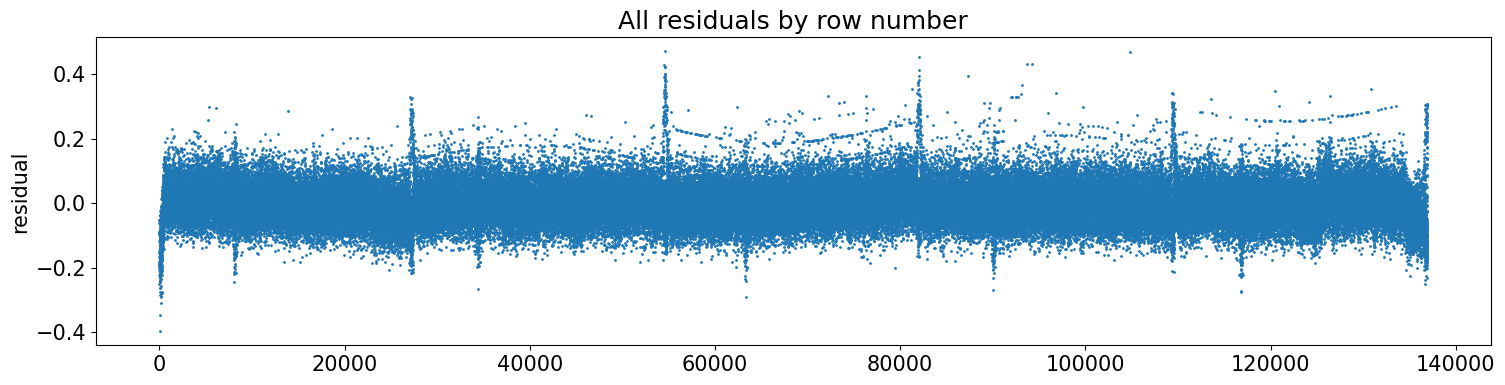

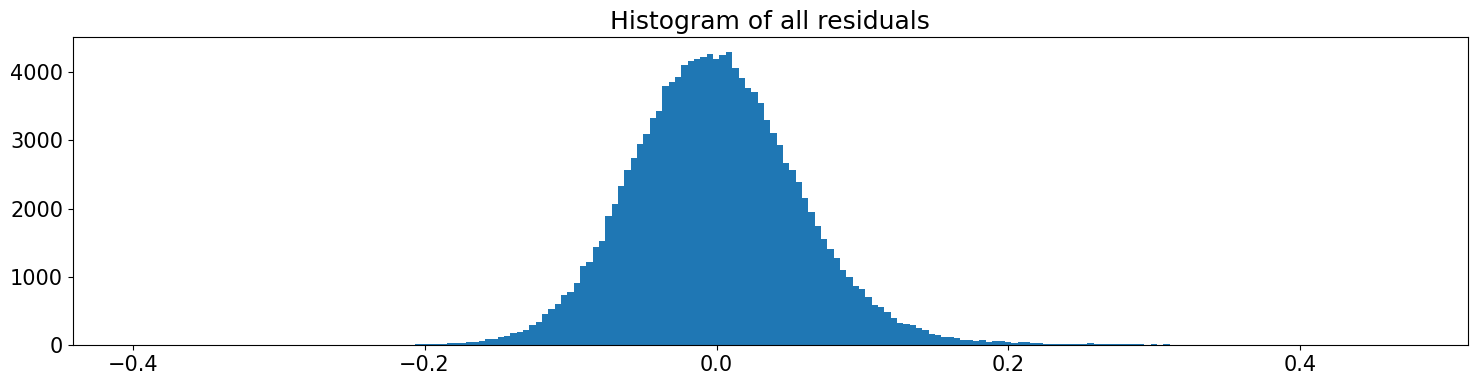

Standard deviation of log residuals: 0.059


In [49]:
residuals = np.log(train_data.predict_exp) - np.log(train_data.num_sold)
plt.figure(figsize=(18, 4))
plt.scatter(np.arange(len(residuals)), residuals, s=1)
plt.title('All residuals by row number')
plt.ylabel('residual')
plt.show()
plt.figure(figsize=(18, 4))
plt.hist(residuals, bins=200)
plt.title('Histogram of all residuals')
plt.show()
print(f"Standard deviation of log residuals: {residuals.std():.3f}")


The residuals are basically uniform. 
However, we see (1): strange straight lines at year end and (2) some strange continuing horizontal lines.
for the second one, I exam all the data carefully and it takes me a lot of time to realize that this feature is due to a special product 'Using LLMs to Win Friends and Influence People'. If we remove this product, the horizontal lines disappear.

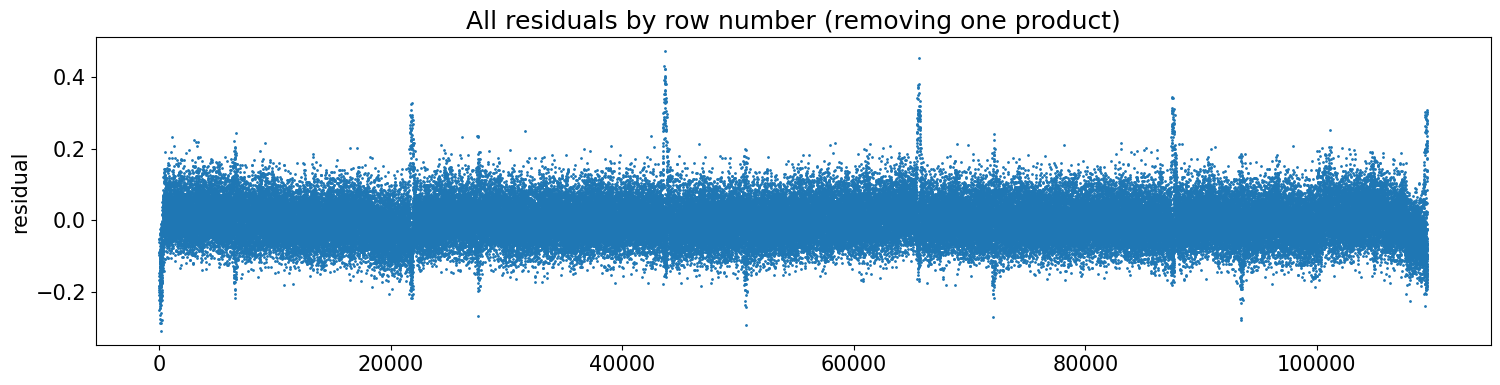

In [50]:
train_data_copy = train_data[train_data['product'] != 'Using LLMs to Win Friends and Influence People'].copy()
residuals = np.log(train_data_copy.predict_exp) - \
    np.log(train_data_copy.num_sold)
plt.figure(figsize=(18, 4))
plt.scatter(np.arange(len(residuals)), residuals, s=1)
plt.title('All residuals by row number (removing one product)')
plt.ylabel('residual')
plt.show()

Below I plot num_sold divided by gdp for each country and store for this special product.

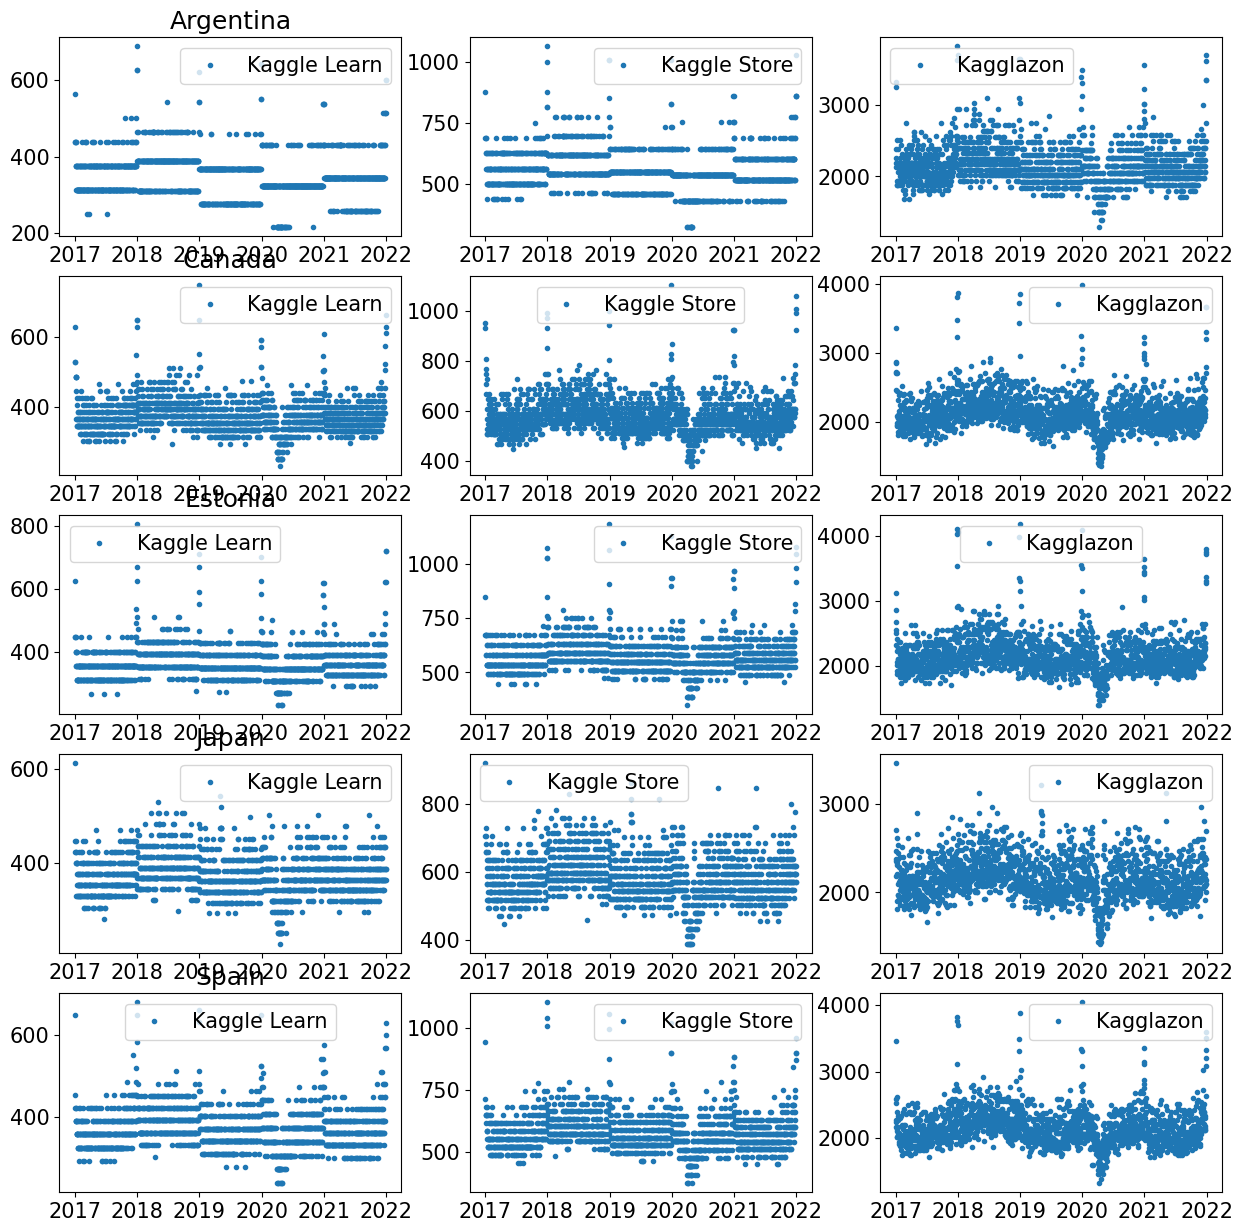

In [51]:
for product in ['Using LLMs to Win Friends and Influence People']:#df['product'].unique():

    countries = df['country'].unique()
    stores = df['store'].unique()
    fig, axs = plt.subplots(len(countries), len(stores), figsize=(15, 3*len(countries))) # adjust figsize as needed
    for country_idx, country in enumerate(countries):
        for store_idx, store in enumerate(stores):
            X = df[(df['country'] == country) & (df['product'] == product) & (df['store'] == store) & (df['date'] < dt.datetime(2022, 1, 1))]
            axs[country_idx, store_idx].plot(
                X['date'], X['num_sold']/X['rel_gdp'],".", label=store)
            axs[country_idx, store_idx].legend()
            if store_idx == 0:
                axs[country_idx, store_idx].set_title(country)

    plt.show()


Upon analyzing the data, we observed that the "num_sold" for Kagglazon exhibits good sine waves. However, for the countries Argentina and Estonia, the "num_sold" for Kaggle Learn and Kaggle Store appear as straight lines. This raises the question of whether these stores are consistently selling the same amount of products each day. Let's delve deeper into the data.

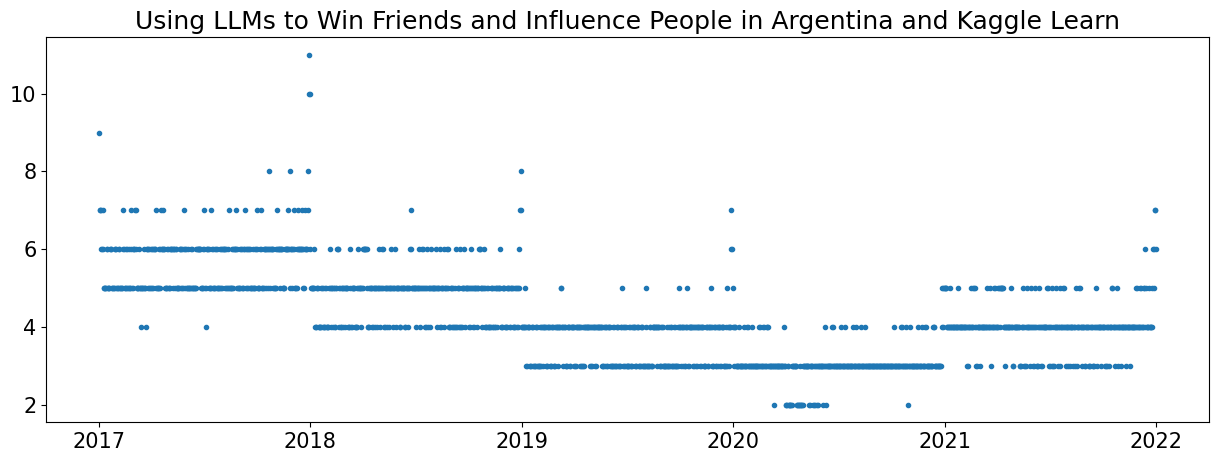

In [52]:

product='Using LLMs to Win Friends and Influence People'
country = 'Argentina'
store = 'Kaggle Learn'
fig=plt.figure(figsize=(15, 5))
X = df[(df['country'] == country) & (df['product'] == product) & (df['store'] == store) & (df['date'] < dt.datetime(2022, 1, 1))]
plt.plot(X['date'], X['num_sold'],".", label=store)
plt.title(f'{product} in {country} and {store}')
plt.show()


After extensive analysis that I didn't show here, I realized that in the residual plot, the horizontal lines observed in the "num_sold" for certain countriesand stores are a result of the small daily amplitude of the "num_sold" values combined with the requirement for "num_sold" to be an integer. Consequently, the true underlying pattern, which might have been sinusoidal, is lost after rounding, and this residual does not provide meaningful insights for data improvement. 

Let's check for the reasons for the straight lines:
The codes below identify potential candidate country-specific holidays from time series data. By calculating residuals and grouping them based on the country and day of the year, it detects significant deviations using z-scores. These deviations may indicate holidays or special events that influence sales pattern

(learned from this post https://www.kaggle.com/code/ambrosm/tpsjan22-03-linear-model/notebook ^ ^ )

In [53]:
from scipy.stats import norm
train_data['dayfix'] = train_data.date.dt.dayofyear
train_data.loc[(train_data.date.dt.year != 2020) & (
    train_data.date.dt.month >= 3), 'dayfix'] += 1

print("Look for residuals beyond", norm.ppf([0.5/365, 364.5/365]))

rr = residuals.groupby([train_data.country, train_data.dayfix]).mean()
rrstd = rr.std()
print(f"Standard deviation when grouped by country and dayofyear: {rrstd:.5f}")
rrdf = pd.DataFrame({'residual': rr, 'z_score': rr / rrstd, 'date': np.datetime64(
    '2016-12-31') + pd.to_timedelta(rr.index.get_level_values(1), 'D')})
rrdf[rrdf.z_score.abs() > 3]


Look for residuals beyond [-2.99552527  2.99552527]
Standard deviation when grouped by country and dayofyear: 0.01910


residual    z_score       date
country   dayfix                                
Argentina 363    -0.057294  -3.000073 2017-12-29
          364    -0.094916  -4.970080 2017-12-30
          365    -0.089103  -4.665691 2017-12-31
          366    -0.079142  -4.144139 2018-01-01
Canada    53      0.061996   3.246319 2017-02-22
          54      0.064000   3.351259 2017-02-23
          147     0.057644   3.018397 2017-05-27
Estonia   363    -0.058419  -3.059002 2017-12-29
          365    -0.061777  -3.234832 2017-12-31
          366    -0.065591  -3.434565 2018-01-01
Japan     1       0.118348   6.197056 2017-01-01
          2       0.058186   3.046802 2017-01-02
          361     0.084126   4.405069 2017-12-27
          362     0.158659   8.307847 2017-12-28
          363     0.242335  12.689414 2017-12-29
          364     0.294515  15.421675 2017-12-30
          365     0.282296  14.781883 2017-12-31
          366     0.231520  12.123086 2018-01-01
Spain     363    -0.074559  -3.904159 2017-12-29
          364    -0.109290  -5.722768 2017-12-30
          365    -0.112117  -5.870775 2017-12-31
          366    -0.087210  -4.566580 2018-01-01

There are many days that have large residuals! And I analyzed these dates separately.

Below is a code example. I check the predicted num_sold and the real num_sold for country Canada at April for different products. The dashed lines show the holiday dates. We can see that that after 4-5 days of the holiday, the predicted num is much larger than the real num. This is because the data doesn't have the holiday effect at this holiday day. So  we need to remove this holiday from our holiday list. Similar things happen for some other holidays. 

Using this analysis, I also find that Japan doesn't celebrate holiday on Christmas and New Year (except for 2017). This is the reason why there is a large residual at the year end.

[         date country
0  2017-04-14  Canada,          date country
0  2017-04-17  Canada]


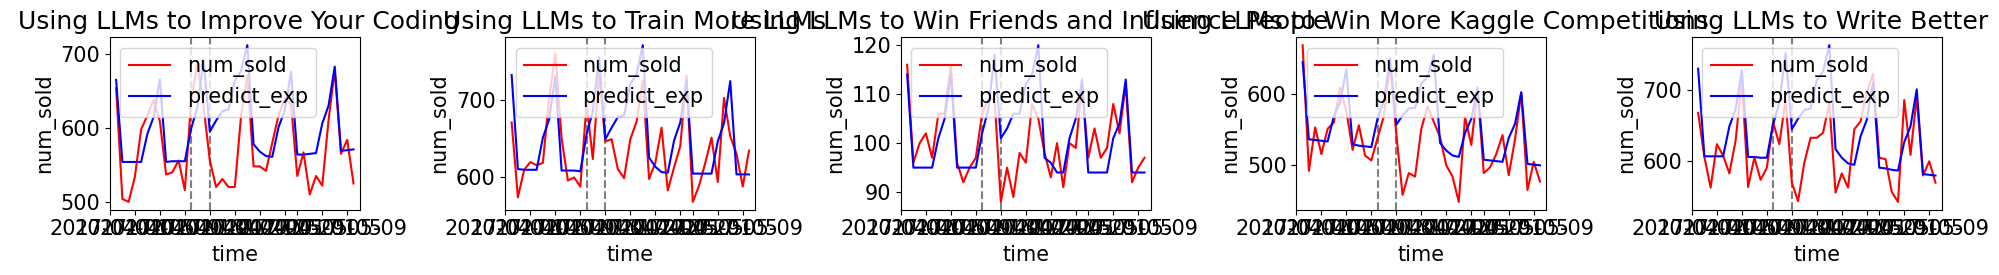

In [54]:
import datetime as dt
import matplotlib.pyplot as plt

country = 'Canada'
result_graph = train_data.loc[(train_data['country'] == country) & (
    train_data['store'] == 'Kagglazon')]

products = uniques['product']
num_products = len(products)
fig, axes = plt.subplots(nrows=1, ncols=num_products, figsize=(20, 3))
i=0
year = 2017 + i
dfs = []
for date, holiday_name in sorted(holidays.CountryHoliday(country, years=year).items()):
    if date.month == 4:
        df0 = pd.DataFrame({"date": [date], "country": [country]})
        dfs.append(df0)
print(dfs)
for j, product in enumerate(products):
    for date, holiday_name in sorted(holidays.CountryHoliday(country, years=year).items()):
        if date.month == 4:
            df0 = pd.DataFrame({"date": [date], "country": [country]})
        axes[j].axvline(x=date, color='gray', linestyle='--')
    dt1, dt2 = dt.datetime(2017 + i, 4, 1), dt.datetime(2017 + i, 5, 11)
    view = result_graph.loc[(result_graph['product'] == product) & (
        result_graph['date'] > dt1)& (result_graph['date'] < dt2)]
    axes[j].plot(view['date'], view['num_sold'], color='red', label='num_sold')
    axes[j].plot(view['date'], np.around(view['predict_exp'], 0),
                 color='blue', label='predict_exp')
    axes[j].set_xlabel('time')
    axes[j].set_ylabel('num_sold')
    axes[j].set_xlim(dt1, dt2)
    axes[j].set_title(f" {product}")
    axes[j].legend()

plt.tight_layout()
plt.show()


I also check for small coefficients:

In [55]:
c_sorted = coef.loc[coef['coef'].abs().sort_values(ascending=False).index]
c_sorted.tail(10)

,coef
column,
Using LLMs to Win More Kaggle Competitions_year_cos_0.5,-0.003177
Using LLMs to Write Better_year_cos_0.5,-0.002553
holiday_9,0.002320
Using LLMs to Win Friends and Influence People_year_sin_1,-0.002212
Using LLMs to Win More Kaggle Competitions_year_sin_1,-0.002077
Using LLMs to Train More LLMs_year_sin_1,-0.001959
Using LLMs to Write Better_year_cos_1,0.001096
Using LLMs to Train More LLMs_year_cos_1,0.001031
Using LLMs to Win Friends and Influence People_year_cos_1,0.000553


It shows that some cosine and sine coefficients are very small. Let's compare them:

In [56]:
coef[coef.index.str.contains('cos_|sin_', case=False)]


,coef
column,
Using LLMs to Improve Your Coding_year_sin_1,-0.151698
Using LLMs to Improve Your Coding_year_cos_1,-0.000269
Using LLMs to Improve Your Coding_year_sin_0.5,-0.005892
Using LLMs to Improve Your Coding_year_cos_0.5,-0.003193
Using LLMs to Train More LLMs_year_sin_1,-0.001959
Using LLMs to Train More LLMs_year_cos_1,0.001031
Using LLMs to Train More LLMs_year_sin_0.5,-0.076005
Using LLMs to Train More LLMs_year_cos_0.5,-0.013245
Using LLMs to Win Friends and Influence People_year_sin_1,-0.002212


for product "Using LLMs to Improve Your Coding" and "Using LLMs to Write Better_year", sin_1 is much bigger than other coefficients.

for product "Using LLMs to Train More LLMs_year_sin", cos_1 is much bigger than other coefficients.

for prodcut "Using LLMs to Train More LLMs" and "Using LLMs to Win Friends and Influence People", sin_0.5 and cos_0.5 are much bigger than sin_1 and cos_1

Let's plot the data to see the feature: Below we plot the num_sold (with a 7-day average rolling window view) to analyze the temporal patterns. We see that a sine wave can nicely fit the data, except for the first ~5 months.

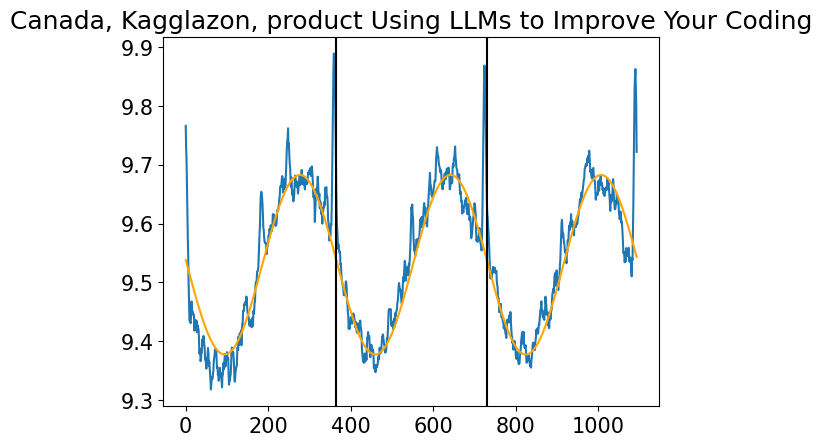

In [57]:
index = 0
view = df.loc[(df['country'] == 'Canada') &
              (df['store'] == 'Kagglazon') &
              (df['product'] == train['product'].unique()[index]),
              ['date', 'log', 'log_rel_gdp','id']]
view['log']-=view['log_rel_gdp']
for i in range(1, 7):
    shifted = view[['date', 'log']].copy()
    shifted['date'] = shifted['date'] - dt.timedelta(days=i)
    view = pd.merge(view, shifted.rename(columns={'log': 'n{}'.format(i)}),
                    how='left', on='date')
view['mean'] = view[['log', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6']].mean(axis=1)
view['time_no'] = (view['date'] - dt.datetime(2017, 1, 1)
                   ) // dt.timedelta(days=1)
view.sort_values('id', inplace=True)
view = view.loc[view['date'] < dt.datetime(2019, 12, 31)]

plt.plot(view['time_no'], view['mean'])
plt.plot(view['time_no'], 9.53-0.1526*np.sin(np.pi *
         (view['time_no'] - 3) / 182.5), color='orange')
plt.axvline(x=365, color='black')
plt.axvline(x=730, color='black')
plt.title('Canada, Kagglazon, product {}'.format(
    train['product'].unique()[index]))
plt.show()


And I did cross validation to confirm that we need only single sin_1/cos_1 wave for some products, and we need only combined sin_0.5 and cos_0.5 for some products. 

# 2. Linear Regression (second round)

1. remove some holidays
2. exclude japan for new year and christmas
2. modify sin and cos patterns

In [58]:
df = pd.concat([train, test], axis=0)
df['log'] = np.log(df['num_sold'])

# add date
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['time_no'] = (df['date'] - dt.datetime(2017, 1, 1)) // dt.timedelta(days=1)
df.loc[df['date'] > dt.datetime(2020, 2, 29), 'time_no'] -= 1


In [59]:
import holidays
import pandas as pd

# Define the years and countries
years = [2017, 2018, 2019, 2020, 2021, 2022]
countries = train.country.unique()

dfs = []
# Generate holidays for each country and year
for year in years:
    for country in countries:
        for date, holiday_name in sorted(holidays.CountryHoliday(country, years=year).items()):

            df_0 = pd.DataFrame({"date": [date], "country": [
                country]})
            dfs.append(df_0)

# Concatenate all the DataFrames
df_holidays = pd.concat(dfs, ignore_index=True)

# Convert 'date' column to datetime
df_holidays['date'] = pd.to_datetime(df_holidays['date'])
df_holidays['tmp'] = 1


In [60]:
#remove certain holidays since the data doesn't have "holiday upturn" on these holidays
df_holidays = df_holidays[~((df_holidays['date'].dt.month.isin([2,4,5,8,10])) & (df_holidays['country'] == 'Canada'))]

In [61]:
# it seems that Japan doesn't celebrate on this day. I remove it and it increases cross validation
df_holidays = df_holidays[~((df_holidays['date'] == pd.to_datetime(
    f'2018-12-24')) & (df_holidays['country'] == 'Japan'))]


In [62]:

# holidays
holidays_columns = []
for i in range(0, 10):
    column = 'holiday_{}'.format(i)
    shifted = df_holidays.rename(columns={'tmp': column})
    shifted['date'] = shifted['date'] + dt.timedelta(days=i)
    df = pd.merge(df, shifted, on=['country', 'date'], how='left')
    df[column].fillna(0, inplace=True)
    df[column] = df[column]
    holidays_columns.append(column)


# New Year's holiday
special_date_columns = []
for day in range(25, 32):
    column = 'day_12_{}'.format(day)
    df[column] = ((df['month'] == 12) & (df['day'] == day) &
                  (df['country'] != 'Japan')).astype(float)
    special_date_columns.append(column)
for day in range(1, 11):
    column = 'day_1_{}'.format(day)
    df[column] = ((df['month'] == 1) & (df['day'] == day) &
                  ((df['year'] == 2017) | (df['country'] != 'Japan'))).astype(float)
    special_date_columns.append(column)


In [63]:
df['rel_gdp'] = df.apply(
    lambda s: rel_gdp_df.loc[s.country, s.date.year], axis=1)
df['log_rel_gdp'] = np.log(df['rel_gdp'])


In [64]:
# prodcut sine and cosine feature.
# sin wave
year_columns = ['year_sin_1', 'year_cos_1', 'year_sin_0.5', 'year_cos_0.5']
df['year_sin_1'] = np.sin(np.pi * df['time_no'] / 182.5)
df['year_cos_1'] = np.cos(np.pi * df['time_no'] / 182.5)
df['year_sin_0.5'] = np.sin(np.pi * df['time_no'] / 365.0)
df['year_cos_0.5'] = np.cos(np.pi * df['time_no'] / 365.0)

# I did cross validation and find that we only need simple sin and cos wave
product_year_columns = []
for product in train['product'].unique():
    df[product] = (df['product'] == product).astype(float)
    product_sin = '{}_sin'.format(product)
    product_cos = '{}_cos'.format(product)
    if product == 'Using LLMs to Train More LLMs' or product == 'Using LLMs to Win Friends and Influence People':
        df[product_sin] = df[product] * df['year_sin_0.5']
        df[product_cos] = df[product] * df['year_cos_0.5']

        product_year_columns.append(product_sin)
        product_year_columns.append(product_cos)
    elif product == 'Using LLMs to Write Better' or product == 'Using LLMs to Improve Your Coding':
        df[product_sin] = df[product] * df['year_sin_1']
        product_year_columns.append(product_sin)
    else:
        df[product_cos] = df[product] * df['year_cos_1']
        product_year_columns.append(product_cos)


In [65]:
# make month flag in 2020
featured_month_columns = []
for month in range(3, 11):
    column = 'month_2020_{}'.format(month)
    df[column] = ((df['year'] == 2020) & (df['month'] == month)).astype(float)
    featured_month_columns.append(column)

# I also add a yearly flag for 2020

each_year_columns = []
for year in [2020]:
    column = 'year_{}'.format(year)
    df[column] = ((df['year'] == year)).astype(float)
    each_year_columns.append(column)


In [66]:
store_columns = []
for store in uniques['store'][1:]:
    column = 'store_{}'.format(store)
    df[column] = ((df['store'] == store)).astype(float)
    # df[column] = ((df['store'] == store) & (df['year'] != 2020)).astype(float)
    store_columns.append(column)

# product
product_columns = []
for product in uniques['product'][1:]:
    column = 'product_{}'.format(product)
    df[column] = (df['product'] == product).astype(float)
    product_columns.append(column)

# week flag
week_columns = []
for week in range(4, 7):
    column = 'week_{}'.format(week)
    df[column] = (df['week'] == week).astype(float)
    week_columns.append(column)


In [67]:
use_columns = []
use_columns.extend(special_date_columns)
use_columns.extend(product_year_columns)
use_columns.extend(holidays_columns)
use_columns.extend(week_columns)
use_columns.extend(store_columns)
use_columns.extend(product_columns)
use_columns.extend(featured_month_columns)
use_columns.extend(each_year_columns)


In [68]:
from scipy import stats
df_used = df.copy()
# Split data into training and testing datasets
# Use the function
date_train = dt.datetime(2021, 12, 31)
train_data = df_used.loc[df_used['date'] <= date_train]
test_data = df_used.loc[(df_used['date'] >= dt.datetime(2022, 1, 1))]


In [69]:
kf = GroupKFold(n_splits=5)
train_a = []
val_a = []
val_Q1_a = []
val_Q234_a = []
for fold, (train_idx, val_idx) in enumerate(kf.split(train_data, groups=train_data.date.dt.year)):
    X_tr = train_data.iloc[train_idx]
    X_va = train_data.iloc[val_idx]
    if X_va.iloc[1].year == 2020:
        continue
    # if X_va.iloc[1].year == 2019:
    #     continue
    print(X_va.iloc[1].year)
    coef, model, train_mean, val_mean, val_Q1, val_Q234 = fit_model(
        X_tr, X_va, use_columns)
    train_a.append(train_mean)
    val_a.append(val_mean)
    val_Q1_a.append(val_Q1)
    val_Q234_a.append(val_Q234)

# Compute mean
train_mean = np.mean(train_a)
val_mean = np.mean(val_a)
val_Q1_mean = np.mean(val_Q1_a)
val_Q234_mean = np.mean(val_Q234_a)

# Compute standard error of the mean
train_sem = stats.sem(train_a)
val_sem = stats.sem(val_a)
val_Q1_sem = stats.sem(val_Q1_a)
val_Q234_sem = stats.sem(val_Q234_a)

print(f"Train mean: {train_mean:.4f} ± {train_sem:.4f}")
print(f"Validation mean: {val_mean:.4f} ± {val_sem:.4f}")
print(f"Validation Q1 mean: {val_Q1_mean:.4f} ± {val_Q1_sem:.4f}")
print(f"Validation Q234 mean: {val_Q234_mean:.4f} ± {val_Q234_sem:.4f}")


2021
train: 4.4194, val: 4.6076, Q1: 4.3438, Q234: 4.6940
2019
train: 4.4466, val: 4.4787, Q1: 4.4704, Q234: 4.4814
2018
train: 4.4871, val: 4.3431, Q1: 4.2774, Q234: 4.3646
2017
train: 4.4135, val: 4.6463, Q1: 5.1261, Q234: 4.4893
Train mean: 4.4417 ± 0.0168
Validation mean: 4.5189 ± 0.0687
Validation Q1 mean: 4.5544 ± 0.1947
Validation Q234 mean: 4.5073 ± 0.0684


In [70]:
# fitting all the data
from scipy import stats
train_data = df_used.loc[df_used['date'] <= date_train]
test_data = df_used.loc[(df_used['date'] >= dt.datetime(2022, 1, 1))]
coef, model, train_mean, test_mean, test_Q1, test_Q234 = fit_model(
    train_data, test_data, use_columns)  # , alpha=150)

train_data['predict_log'] = model.predict(
    train_data[use_columns])+train_data['log_rel_gdp']
train_data['predict_exp'] = np.exp(train_data['predict_log'])
train_data['smape_exp'] = 2 * (train_data['num_sold'] - train_data['predict_exp']).abs() / \
    (train_data['num_sold'] + train_data['predict_exp'])


train: 4.4507, val: 99.6788, Q1: 99.1331, Q234: 99.8574


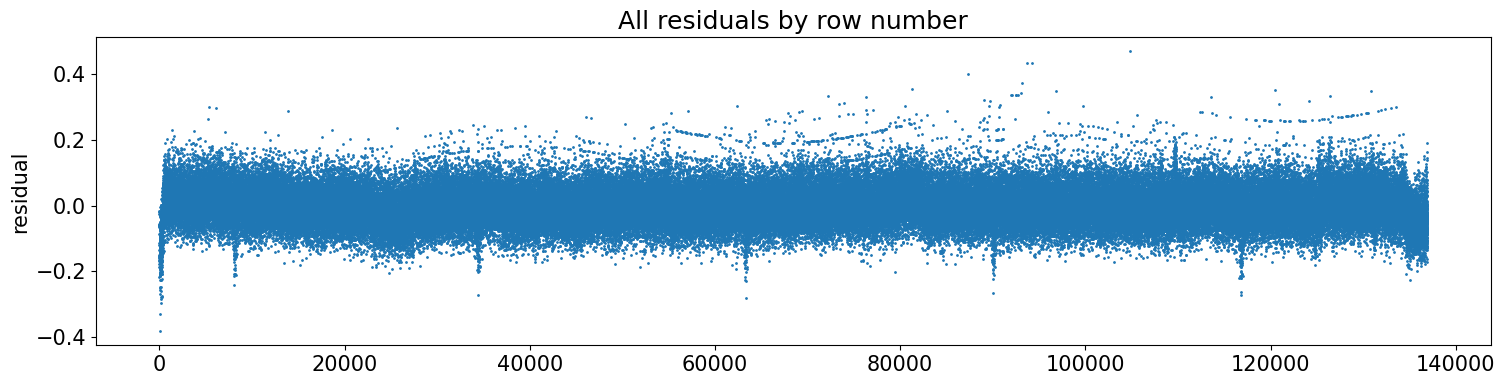

In [71]:
residuals = np.log(train_data.predict_exp) - np.log(train_data.num_sold)
plt.figure(figsize=(18, 4))
plt.scatter(np.arange(len(residuals)), residuals, s=1)
plt.title('All residuals by row number')
plt.ylabel('residual')
plt.show()

In [72]:
from scipy.stats import norm
train_data['dayfix'] = train_data.date.dt.dayofyear
train_data.loc[(train_data.date.dt.year != 2020) & (
    train_data.date.dt.month >= 3), 'dayfix'] += 1

print("Look for residuals beyond", norm.ppf([0.5/365, 364.5/365]))

rr = residuals.groupby([train_data.country, train_data.dayfix]).mean()
rrstd = rr.std()
print(f"Standard deviation when grouped by country and dayofyear: {rrstd:.5f}")
rrdf = pd.DataFrame({'residual': rr, 'z_score': rr / rrstd, 'date': np.datetime64(
    '2016-12-31') + pd.to_timedelta(rr.index.get_level_values(1), 'D')})
rrdf[rrdf.z_score.abs() > 3]


Look for residuals beyond [-2.99552527  2.99552527]
Standard deviation when grouped by country and dayofyear: 0.01110


residual   z_score       date
country   dayfix                               
Argentina 97     -0.039627 -3.568790 2017-04-07
          98     -0.041256 -3.715553 2017-04-08
          110    -0.033839 -3.047531 2017-04-20
          197     0.033817  3.045621 2017-07-16
          283     0.033480  3.015191 2017-10-10
Canada    1       0.038820  3.496153 2017-01-01
          364     0.035375  3.185884 2017-12-30
          365     0.052343  4.714061 2017-12-31
          366     0.063555  5.723808 2018-01-01
Japan     1      -0.039636 -3.569640 2017-01-01
          2      -0.036255 -3.265137 2017-01-02
          4      -0.033560 -3.022459 2017-01-04
Spain     364    -0.038035 -3.425446 2017-12-30
          365    -0.041617 -3.748093 2017-12-31

After observing the data, we found that only a few days exhibit large residuals. Upon analyzing the holidays, we find that Canada and Estonia have holidays on 12.26 and 12.27, respectively. We intend to treat these holidays separately to account for their distinct impact on the data. Additionally, as the model already incorporates a separate representation of the New Year "Big" holiday, we aim to avoid multicollinearity issues by removing 1.1 and 12.25 from the holiday list. This ensures a more accurate and meaningful analysis of the data's behavior 

Let's check the holiday coefficents.

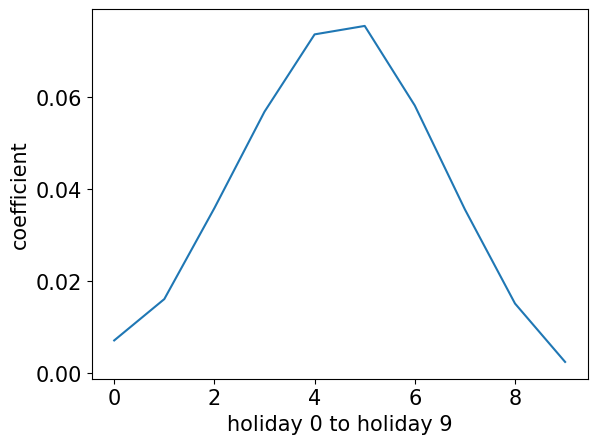

In [73]:

plt.plot(coef.loc['holiday_0':'holiday_9', 'coef'].values)
x = np.arange(0, 9, 0.1)
plt.xlabel('holiday 0 to holiday 9')
plt.ylabel('coefficient')
plt.show()


We see that the holiday coefficient has a normal distribution with mean value at 4.5 days after the holiday. Let's do a gaussian curve to fit it.

0.07709728152611485 7.778957108611124


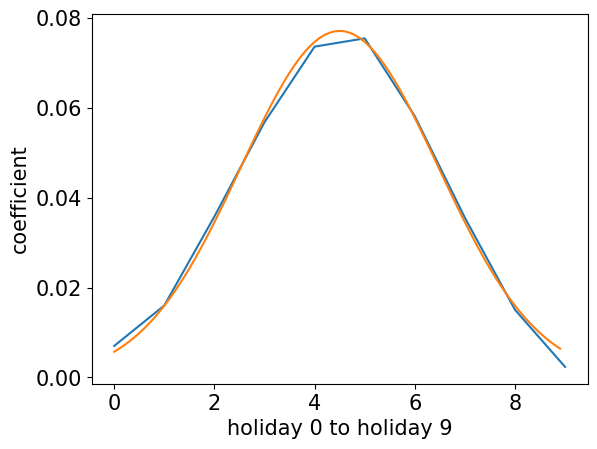

In [74]:
from scipy.optimize import curve_fit
def gauss_function(x, a, sigma):
    return a*np.exp(-(x-4.5)**2/(sigma))

y = coef.loc['holiday_0':'holiday_9', 'coef'].values
x = np.linspace(0, len(y) - 1, len(y))
popt, pcov = curve_fit(gauss_function, x, y)
a,  sigma = popt
print(a, sigma)
plt.plot(coef.loc['holiday_0':'holiday_9', 'coef'].values)
x = np.arange(0, 9, 0.1)
plt.plot(x, a * np.exp(-(x-4.5)**2/sigma))
plt.xlabel('holiday 0 to holiday 9')
plt.ylabel('coefficient')
plt.show()


We see that a gaussian curve is a very good fit to it.

# 2. Linear Regression (third round)

1. Remove the repeated holidays on Christmas and New Year's Day.
2. Handle the holidays on 12.26 for Canada and Estonia separtely.
3. Use gaussian curves to fit the holiday coefficients 1-10


# 2. Linear Regression (fourth round)

1. Plot the Ridge Regression coefficients as a function of the regularization to find the optimal alpha.
2. Try removing the parameter (year_2020), and adding another parameter year_2019_Dec, it indeed imrpvoes the score for data during year 2017-2021, but it doesn't imrpvoe the score on public leaderboard. In the end I submit two versions. And the version without these 2 parameters has a better score.


3. After these fittings, the residual still has a very slight monthly pattern and is not very uniform, as shown something like below.
I try adding the cci data as suggested in previous posts, while it doesn't improve my CV score. Maybe it should be added using a nonlinear way? Or there is something else that I missed? I'm not sure. In the end I didn't add more parameters to fit it.

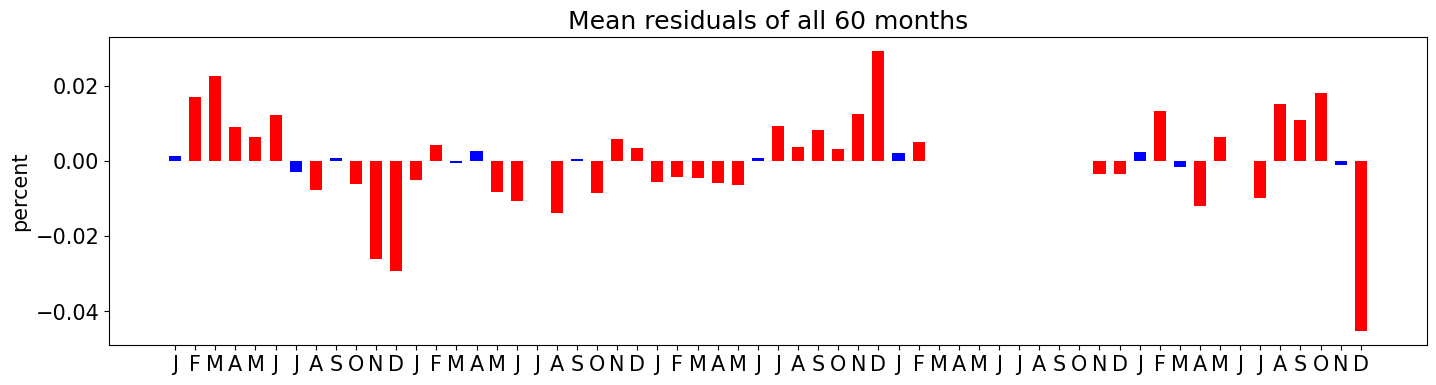

In [75]:
import scipy
def plot_unexplained(residuals, groups, labels=None, label_z_score=False, title=None):
    residuals_grouped = residuals.groupby(groups)
    means = residuals_grouped.mean()
    counts = residuals_grouped.count()
    z_score = np.sqrt(counts) * means / residuals.std()
    z_threshold = scipy.stats.norm.ppf(1 - 0.25 / len(means))
    m_threshold = z_threshold * residuals.std() / np.sqrt(counts.mean())
    outliers = np.abs(z_score) > z_threshold
    plt.figure(figsize=(17, 4))
    # plt.hlines([-z_threshold, +z_threshold] if label_z_score else [-m_threshold, +m_threshold], 0, len(means)-1, color='k')
    plt.bar(range(len(means)), z_score if label_z_score else means,
            color=outliers.apply(lambda b: 'r' if b else 'b'), width=0.6)
    if labels is not None:
        plt.xticks(ticks=range(len(means)), labels=labels)
    plt.ylabel('z score' if label_z_score else 'percent')
    plt.title(title)
    plt.show()


plot_unexplained(residuals, [train_data.date.dt.year, train_data.date.dt.month],
                 labels="JFMAMJJASOND" * 5,
                 title='Mean residuals of all 60 months')


### Final submission:

In [76]:

df = pd.concat([train, test], axis=0)
df['log'] = np.log(df['num_sold'])

# add date
df['date']  = pd.to_datetime(df['date'])
df['year']  = df['date'].dt.year
df['week']  = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['day']   = df['date'].dt.day
df['time_no'] = (df['date'] - dt.datetime(2017, 1, 1)) // dt.timedelta(days=1)
df.loc[df['date'] > dt.datetime(2020, 2, 29), 'time_no'] -= 1



In [77]:
# Define the years and countries
years = [2017,2018,2019,2020,2021,2022]
countries = train.country.unique()

dfs = []
# Generate holidays for each country and year
for year in years:
    for country in countries:
        for date, holiday_name in sorted(holidays.CountryHoliday(country, years=year).items()):
            
            df_0 = pd.DataFrame({"date": [date], "country": [
                              country]})
            dfs.append(df_0)

# Concatenate all the DataFrames
df_holidays = pd.concat(dfs, ignore_index=True)

# Convert 'date' column to datetime
df_holidays['date'] = pd.to_datetime(df_holidays['date'])
df_holidays['tmp'] = 1

#remove certain holidays since the data doesn't have "holiday upturn" on these holidays
df_holidays = df_holidays[~((df_holidays['date'].dt.month.isin([2,4,5,8,10])) & (df_holidays['country'] == 'Canada'))]
# remove New Year and Christmas Holiday because I will handle them seperately
for country in ['Argentina', 'Canada', 'Estonia', 'Spain']:
    for year in years:
        df_holidays = df_holidays[~((df_holidays['date'] == pd.to_datetime(
            f'{year}-01-01')) & (df_holidays['country'] == country))]
df_holidays = df_holidays[~((df_holidays['date'] == pd.to_datetime(
    '2017-01-02')) & (df_holidays['country'] == 'Spain'))]

for country in ['Argentina', 'Canada', 'Estonia', 'Spain']:
    for year in years:
        df_holidays = df_holidays[~((df_holidays['date'] == pd.to_datetime(
            f'{year}-12-25')) & (df_holidays['country'] == country))]
df_holidays = df_holidays[~((df_holidays['date'] == pd.to_datetime(
    '2022-12-26')) & (df_holidays['country'] == 'Spain'))]

# Canada and Estonia has additional holiday on 26th following Christmas. I will handle them separately
for country in ['Canada', 'Estonia']:
    for year in years:
        df_holidays = df_holidays[~((df_holidays['date'] == pd.to_datetime(
            f'{year}-12-26')) & (df_holidays['country'] == country))]

#Canada has additional holiday on 27, 28. I remove them and it increases cross validation
df_holidays = df_holidays[~((df_holidays['date'] == pd.to_datetime('2020-12-28')) & (df_holidays['country'] == 'Canada'))]
df_holidays = df_holidays[~((df_holidays['date'] == pd.to_datetime('2021-12-27')) & (df_holidays['country'] == 'Canada'))]
df_holidays = df_holidays[~((df_holidays['date'] == pd.to_datetime('2021-12-28')) & (df_holidays['country'] == 'Canada'))]
df_holidays = df_holidays[~((df_holidays['date'] == pd.to_datetime('2022-12-27')) & (df_holidays['country'] == 'Canada'))]

#it seems that Japan doesn't celebrate on this day. I remove it and it increases cross validation
df_holidays = df_holidays[~((df_holidays['date'] == pd.to_datetime(
            f'2018-12-24')) & (df_holidays['country'] == 'Japan'))]

In [78]:
def get_gdp_per_capita(country, year):
    alpha3 = {'Argentina': 'ARG', 'Canada': 'CAN',
              'Estonia': 'EST', 'Japan': 'JPN', 'Spain': 'ESP'}
    url = "https://api.worldbank.org/v2/country/{0}/indicator/NY.GDP.PCAP.CD?date={1}&format=json".format(
        alpha3[country], year)
    response = requests.get(url).json()
    return response[1][0]['value']


gdp = []
for country in train.country.unique():
    row = []
    for year in range(2017, 2023):
        row.append(get_gdp_per_capita(country, year))
    gdp.append(row)

gdp = np.array(gdp)
gdp /= np.sum(gdp)

rel_gdp_df = pd.DataFrame(gdp, index=train.country.unique(), columns=range(2017, 2023))
df['rel_gdp'] = df.apply(lambda s: rel_gdp_df.loc[s.country, s.date.year], axis=1)
df['log_rel_gdp'] = np.log(df['rel_gdp'])


In [79]:
# holiday
holiday_diff = [np.exp(-(i - 4.5) ** 2 / 8.5) for i in range(11)]
holidays_columns = ['holiday']
df['holiday'] = 0
for day_no, diff in enumerate(holiday_diff):
    shifted = df_holidays.copy()
    shifted['date'] = shifted['date'] + dt.timedelta(days=day_no)
    df = pd.merge(df, shifted, on=['country', 'date'], how='left')
    df['tmp'].fillna(0, inplace=True)
    df['holiday'] += df['tmp'] * diff
    df.drop(columns='tmp', inplace=True)
# New Year's holiday
special_date_columns = []
for day in range(25, 32):
    column = 'day_12_{}'.format(day)
    df[column] = ((df['month'] == 12) & (df['day'] == day) &
                  (df['country'] != 'Japan')).astype(float)
    special_date_columns.append(column)
for day in range(1, 11):
    column = 'day_1_{}'.format(day)
    df[column] = ((df['month'] == 1) & (df['day'] == day) & 
                  ((df['year'] == 2017) | (df['country'] != 'Japan'))).astype(float)
    special_date_columns.append(column)
holiday_countries = ['Estonia','Canada']
column = 'holiday_1226'
holiday_diff = [np.exp(-(i - 4.5) ** 2 / 8.5) for i in range(11)]
df[column] = 0
for day_no, diff in enumerate(holiday_diff):
    df.loc[(df['country'].isin(holiday_countries)) & (df['month'] == 12) & (df['day'] == 26 + day_no), column] = diff
    df.loc[(df['country'].isin(holiday_countries)) & (df['month'] ==  1) & (df['day'] == -5 + day_no), column] = diff

special_date_columns.append(column)

In [80]:
# sin wave
year_columns = ['year_sin_1', 'year_cos_1', 'year_sin_0.5', 'year_cos_0.5']
df['year_sin_1']   = np.sin(np.pi * df['time_no'] / 182.5)
df['year_cos_1']   = np.cos(np.pi * df['time_no'] / 182.5)
df['year_sin_0.5'] = np.sin(np.pi * df['time_no'] / 365.0)
df['year_cos_0.5'] = np.cos(np.pi * df['time_no'] / 365.0)

# prodcut feature.
#I did crossvalidation and find that we only need simple sin and cos wave
product_year_columns = []
for product in train['product'].unique():
    df[product] = (df['product'] == product).astype(float)
    product_sin = '{}_sin'.format(product)
    product_cos = '{}_cos'.format(product)
    if product == 'Using LLMs to Train More LLMs' or product == 'Using LLMs to Win Friends and Influence People':
        df[product_sin] = df[product] * df['year_sin_0.5']
        df[product_cos] = df[product] * df['year_cos_0.5']

        product_year_columns.append(product_sin)
        product_year_columns.append(product_cos)
    elif product == 'Using LLMs to Write Better' or product== 'Using LLMs to Improve Your Coding':
        df[product_sin] = df[product] * df['year_sin_1']
        product_year_columns.append(product_sin)    
    else:
        df[product_cos] = df[product] * df['year_cos_1']
        product_year_columns.append(product_cos)

In [81]:
# make month flag in 2020
featured_month_columns = []
for month in range(3, 11):
    column = 'month_2020_{}'.format(month)
    df[column] = ((df['year'] == 2020) & (df['month'] == month)).astype(float)
    featured_month_columns.append(column)

In [82]:
# week flag
week_columns = []
for week in range(4, 7):
    column = 'week_{}'.format(week)
    df[column] = (df['week'] == week).astype(float)
    week_columns.append(column)
store_columns = []

for store in train.store.unique()[1:]:
    column = 'store_{}'.format(store)
    df[column] = ((df['store'] == store)).astype(float)
    #df[column] = ((df['store'] == store) & (df['year'] != 2020)).astype(float)
    store_columns.append(column)
# product
product_columns = []
for product in train['product'].unique()[1:]:
    column = 'product_{}'.format(product)
    df[column] = (df['product'] == product).astype(float)
    product_columns.append(column)

In [83]:
from sklearn.linear_model import Ridge
# decide use columns
use_columns = []
use_columns.extend(special_date_columns)
use_columns.extend(product_year_columns)
use_columns.extend(holidays_columns)
use_columns.extend(week_columns)
use_columns.extend(store_columns)
use_columns.extend(product_columns)
use_columns.extend(featured_month_columns)


# learning
df_used = df.copy()
date = dt.datetime(2021, 12, 31)
df_used = df_used.loc[df_used['date'] <= date]
source = df_used[use_columns]
target = df_used['log']-df_used['log_rel_gdp']

model = Pipeline([
    ('standardize', StandardScaler()),
    ('linear_reg', Ridge(alpha=150, tol=0.00001, max_iter=10000))

])
model.fit(source, target)
linear_reg_model = model.named_steps['linear_reg']
coef = pd.DataFrame(linear_reg_model.coef_, columns=['coef'])
coef['column'] = source.columns
coef.set_index('column', inplace=True)
coef.loc['intercept'] = linear_reg_model.intercept_

In [84]:
coef

,coef
column,
day_12_25,0.002709
day_12_26,0.006181
day_12_27,0.011688
day_12_28,0.017674
day_12_29,0.021872
day_12_30,0.021732
day_12_31,0.018001
day_1_1,0.013165
day_1_2,0.008402


In [85]:
# show results
df['predict_log'] = model.predict(df[use_columns])+df['log_rel_gdp']
df['predict_exp'] = np.exp(df['predict_log'])


df['smape_log'] = 2 * (df['log'] - df['predict_log']).abs() / (df['log'] + df['predict_log'])

df['smape_exp'] = 2 * (df['num_sold'] - df['predict_exp']).abs() / (df['num_sold'] + df['predict_exp'])

result = df.loc[df['date'] <= date]
print('e smape  = {}'.format(result['smape_exp'].mean()))

e smape  = 0.04441660823123545


In [86]:
result = df.sort_values('id')
result_2 = result.copy()
result_2.loc[(result_2['year'] == 2022)&(result_2['country'] == 'Argentina'), 'predict_exp'] *= 3.372
result_2.loc[(result_2['year'] == 2022)&(result_2['country'] == 'Spain'), 'predict_exp'] *= 1.6
result_2.loc[(result_2['year'] == 2022)&(result_2['country'] == 'Japan'), 'predict_exp'] *= 1.394
result_2.loc[(result_2['year'] == 2022)&(result_2['country'] == 'Estonia'), 'predict_exp'] *= 1.651
result_2.loc[(result_2['year'] == 2022)&(result_2['country'] == 'Canada'), 'predict_exp'] *= 0.850
result_2 = result_2.loc[result_2['date'] >= dt.datetime(2022, 1, 1), ['id', 'predict_exp']]


#round
result_2['predict_exp'] = np.round(result_2['predict_exp'],0)
result_2.rename(columns={'predict_exp':'num_sold'}).to_csv('submission.csv', header=True, index=False)

In the final step of the analysis, we multiply the results obtained from each country by a constant. A discussion thread (https://www.kaggle.com/competitions/playground-series-s3e19/discussion/425538) sheds light on this process, suggesting that every country moves to the same level in 2022. Consequently, I think we can assume that the first quarter of 2022 serves as "known data," using it to predict the sales for the remaining three quarters, though personally I really don't like such ideas..

a section of the predicted data in 2022 is shown below.


Using LLMs to Improve Your Coding


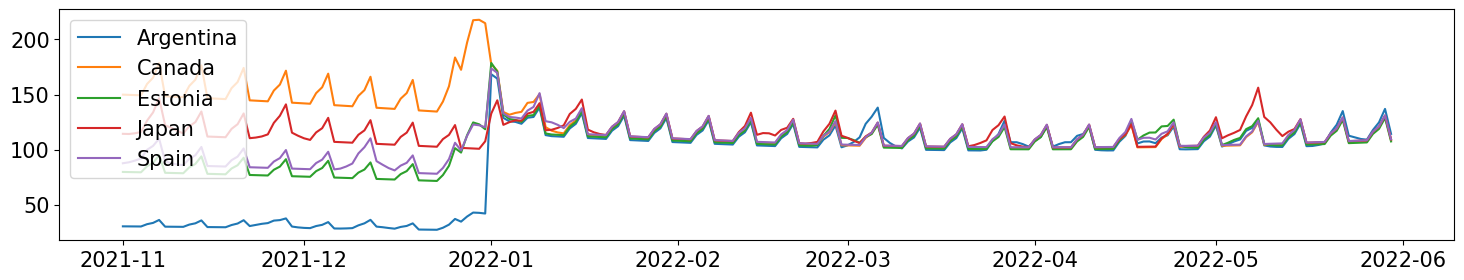

Using LLMs to Train More LLMs


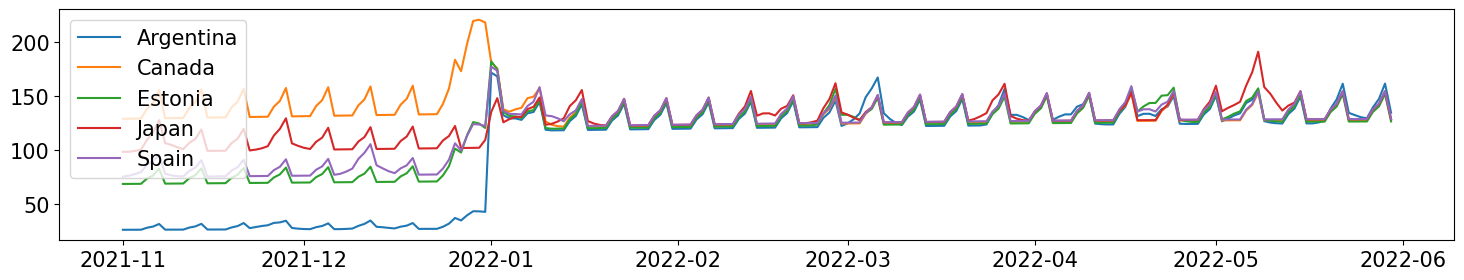

Using LLMs to Win Friends and Influence People


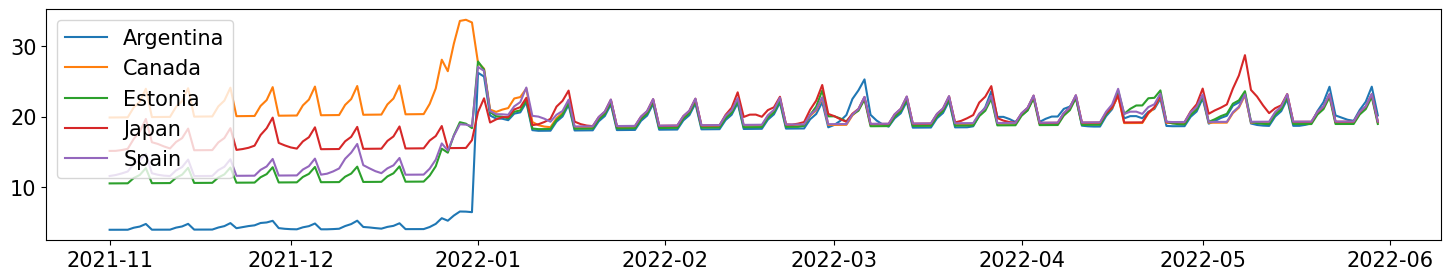

Using LLMs to Win More Kaggle Competitions


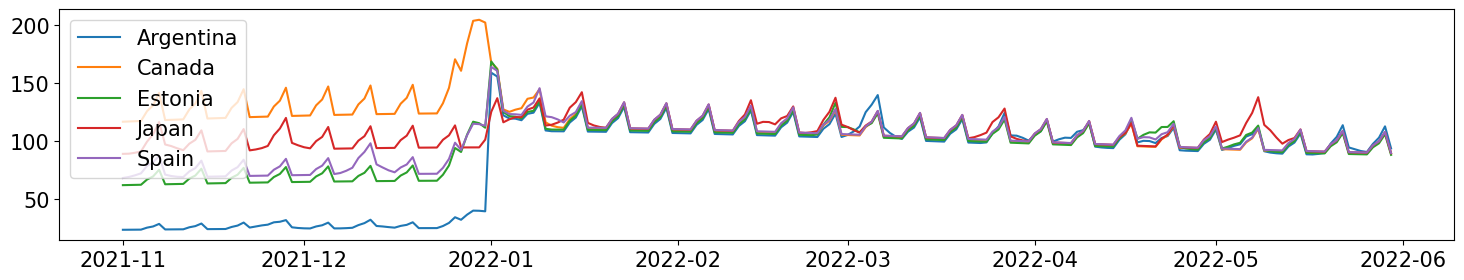

Using LLMs to Write Better


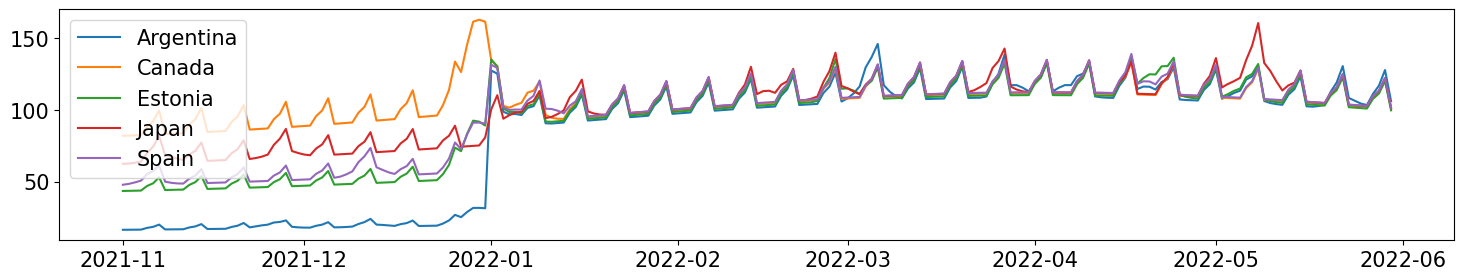

In [87]:
result = df.sort_values('id')
result_2 = result.copy()
result_2.loc[(result_2['year'] == 2022)&(result_2['country'] == 'Argentina'), 'predict_exp'] *= 3.372
result_2.loc[(result_2['year'] == 2022)&(result_2['country'] == 'Spain'), 'predict_exp'] *= 1.6
result_2.loc[(result_2['year'] == 2022)&(result_2['country'] == 'Japan'), 'predict_exp'] *= 1.394
result_2.loc[(result_2['year'] == 2022)&(result_2['country'] == 'Estonia'), 'predict_exp'] *= 1.651
result_2.loc[(result_2['year'] == 2022)&(result_2['country'] == 'Canada'), 'predict_exp'] *= 0.850


# First loop over products
for i, product in enumerate(train['product'].unique()):
    print(product)
    fig = plt.figure(figsize=(18, 3))

    # Then loop over countries for each product
    for country in train['country'].unique():
        result_graph = result_2.loc[(result['country'] == country) &
                                  (result['store'] == 'Kaggle Learn') & (result['date'] > dt.datetime(2021, 10, 31)) & (result['date'] < dt.datetime(2022, 5, 31))]
        view = result_graph.loc[result_graph['product'] == product]
        plt.plot(view['date'], view['predict_exp'],label=country)
    plt.legend()
    plt
    plt.show()

Useful link:

https://www.kaggle.com/competitions/playground-series-s3e19/discussion/423643

From this competition, we see that a linear regression model can be really powerful after we perform good feature engineering.